# Introduction

Deeds (Digital Electronic Education and Design Suite) (Ponta et al., 1998) is a simulation environment for e-learning in digital electronics. The environment provides learning materials through specialized browsers for the students, and asks them to solve various problems with different levels of difficulty. 

The EPM dataset was collected from University of Genoa by using Deeds, 115 first-year engineering students are required to use Deeds to learn digital electronics which consists of 6 sessions. All the log data of students using Deeds system was collected during the process of learning: activities, time, mouse clicks and key strokes. At the end of each session, students needed to finish an assignment, and the grade of the assignment was recorded in the intermediate grade dataset. In the end of the semester, final exam grades of all students was recorded in the final grades dataset. 

The main purpose of our project is to build a model that can predict whether a student can pass the final exam based on their logs data of laboratory sessions recorded on the Deeds system. By using this model, the instructors can notify those who-may-fail-at-final to help them re-catching the learning schedule.

In [1]:
import requests
import zipfile
import io
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

%matplotlib inline

# Gathering Data

Download dataset:

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00346/EPMDataset%20.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('../educational-process-mining')

Input all the sessions data:

In [3]:
# read all the session data and save them into a dictionary
sessions = {}
for x in range(1, 7):
    path = '../educational-process-mining/EPM Dataset 2/Data/Processes/Session {0}'.format(x)
    session = glob.glob(os.path.join(path, '*'))
    dataframes = (pd.read_csv(f, names=['session', 'student_Id', 'exercise', 'activity',
                                        'start_time', 'end_time', 'idle_time', 'mouse_wheel', 
                                        'mouse_wheel_click', 'mouse_click_left', 'mouse_click_right', 
                                        'mouse_movement', 'keystroke']) for f in session)
    sessions['session{0}'.format(x)] = pd.concat(dataframes, ignore_index=True, sort=False)

In [4]:
sessions['session1'].head()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,1,59,Es,Other,2.10.2014 11:24:0,2.10.2014 11:24:3,421,0,0,2,0,106,0
1,1,59,Es,Deeds,2.10.2014 11:24:5,2.10.2014 11:25:42,4573639,0,0,2,0,107,0
2,1,59,Es,Blank,2.10.2014 11:25:43,2.10.2014 11:25:44,0,0,0,2,0,123,0
3,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:25:45,2.10.2014 11:26:46,1652751,0,0,2,0,107,0
4,1,59,Es_1_1,Deeds,2.10.2014 11:26:47,2.10.2014 11:26:47,0,0,0,2,0,18,0


In [5]:
sessions['session2'].head()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,2,61,Es,Other,16.10.2014 11:55:13,16.10.2014 11:55:20,1607,0,0,2,0,350,0
1,2,61,Es,Aulaweb,16.10.2014 11:55:21,16.10.2014 11:55:26,94,7,0,8,0,334,0
2,2,61,Es_2_1,TextEditor_Es_2_1,16.10.2014 11:55:27,16.10.2014 11:55:31,217,3,0,8,0,210,6
3,2,61,Es_2_1,Study_Es_2_1,16.10.2014 11:55:32,16.10.2014 11:55:33,16,0,0,0,0,0,9
4,2,61,Es_2_1,Aulaweb,16.10.2014 11:55:34,16.10.2014 11:55:34,0,0,0,0,0,0,2


In [6]:
sessions['session6'].tail()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
53165,6,25,Es_6_3,Study_Es_6_3,11.12.2014 14:23:23,11.12.2014 14:23:25,15,0,0,2,0,40,0
53166,6,25,Es_6_3,Other,11.12.2014 14:23:26,11.12.2014 14:23:29,157,0,0,2,0,160,0
53167,6,25,Es_6_3,Other,11.12.2014 14:23:30,11.12.2014 14:23:30,0,0,0,2,0,32,0
53168,6,25,Es_6_3,Other,11.12.2014 14:23:31,11.12.2014 14:23:32,0,0,0,3,0,77,0
53169,6,25,Es_6_3,Blank,11.12.2014 14:23:33,11.12.2014 14:23:34,0,0,0,1,0,79,0


Input log data:

In [7]:
logs = pd.read_csv('../educational-process-mining/EPM Dataset 2/Data/logs.txt', sep='\t')

In [8]:
logs.head()

,Student Id,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6
0,1,1,1,0,1,1,1
1,2,1,1,1,1,1,1
2,3,0,1,1,1,1,0
3,4,1,1,1,1,1,1
4,5,1,1,1,1,1,1


Final grades data:

In [9]:
final_grades_1st = pd.read_excel('../educational-process-mining/EPM Dataset 2/Data/final_grades.xlsx', sheet_name='Exam (First time)')
final_grades_2nd = pd.read_excel('../educational-process-mining/EPM Dataset 2/Data/final_grades.xlsx', sheet_name='Exam (Second time)')

In [10]:
final_grades_1st.head()

,Student ID,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),TOTAL\n(100 points)
0,3,2.0,3,1.0,2.0,1,2,2,2.0,3.0,15.0,10.0,1,5.0,3.0,18.0,15,85.0
1,6,2.0,3,2.0,3.0,1,2,2,0.0,3.0,15.0,7.0,2,9.0,3.0,13.0,15,82.0
2,7,2.0,3,1.0,1.5,1,2,0,0.0,3.0,5.0,4.0,0,0.0,3.0,17.0,10,52.5
3,10,2.0,3,2.0,1.5,1,2,0,2.0,3.0,11.0,1.0,2,10.0,1.5,7.0,10,59.0
4,13,2.0,3,2.0,1.5,1,2,2,2.0,3.0,14.5,10.0,2,2.0,3.0,25.0,15,90.0


In [11]:
final_grades_2nd.head()

,Student ID,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),TOTAL\n(100 points)
0,1,2.0,3.0,1.0,0.5,1.0,2,2.0,2,3,15,10.0,2.0,10.0,3.0,25.0,13.0,94.5
1,2,2.0,3.0,2.0,0.5,1.0,2,0.0,2,3,15,2.0,0.0,5.0,1.5,5.0,0.0,44.0
2,4,2.0,3.0,1.0,0.5,1.0,2,0.0,2,0,3,4.0,0.0,1.5,0.0,5.0,5.0,30.0
3,5,2.0,3.0,2.0,1.5,1.0,2,2.0,2,3,3,2.0,1.5,9.0,1.5,2.0,1.0,38.5
4,7,2.0,3.0,1.0,1.5,1.0,2,2.0,2,3,15,10.0,1.0,2.5,0.0,20.0,12.0,78.0


Intermediate grades data:

In [12]:
inter_grades = pd.read_excel('../educational-process-mining/EPM Dataset 2/Data/intermediate_grades.xlsx')

In [13]:
inter_grades.head()

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
0,1,5.0,0.0,4.5,4.0,2.25
1,2,4.0,3.5,4.5,4.0,1.00
2,3,3.5,3.5,4.5,4.0,0.00
3,4,6.0,4.0,5.0,3.5,2.75
4,5,5.0,4.0,5.0,4.0,2.75


# Accessing Data

There are some 0 scores in the intermediate grades dataset, and we know that the logs dataset marked all the student has log in a session with value 1, while those has not log in a session with value 0, so here comes the question: were all the students without log got a 0 score in the intermediate grades?

We can use the test below to check this question:

In [14]:
no_inter_grades = (inter_grades == 0)
no_inter_grades

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
0,False,False,True,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,True
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
110,False,False,True,True,False,True
111,False,True,True,True,True,True
112,False,True,True,True,True,True
113,False,True,True,True,True,True


In [15]:
no_log = (logs == 0)
no_log

,Student Id,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6
0,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False
2,False,True,False,False,False,False,True
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
110,False,False,True,True,True,True,True
111,False,False,True,True,True,True,True
112,False,False,True,True,True,True,True
113,False,False,True,True,True,True,True


In [16]:
no_log.drop('Session 1', axis=1, inplace=True)

In [17]:
no_log

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
0,False,False,True,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,True
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
110,False,True,True,True,True,True
111,False,True,True,True,True,True
112,False,True,True,True,True,True
113,False,True,True,True,True,True


In [18]:
no_grade_contrast = (no_log != no_inter_grades)

In [19]:
no_grade_contrast.loc[no_grade_contrast['Session 2'] == True]

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
26,False,True,False,False,False,False
34,False,True,False,False,False,False
54,False,True,False,False,False,True
59,False,True,True,False,False,False
60,False,True,False,False,False,False
65,False,True,False,False,False,False
67,False,True,False,False,False,False
88,False,True,False,False,False,False
106,False,True,False,False,False,False
110,False,True,False,False,True,False


All those True values means that not all the no log students get a zero score in intermediate grades. We can dig into those student Id to have a look of it.

In [20]:
se2_index = no_grade_contrast.loc[no_grade_contrast['Session 2'] == True].index

In [21]:
inter_grades.iloc[se2_index]

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
26,27,0.0,3.0,4.5,4.0,1.75
34,35,0.5,0.5,3.5,3.5,1.50
54,55,2.0,3.5,4.5,4.0,2.50
59,60,2.0,0.5,4.0,3.5,1.00
60,61,0.0,1.0,4.5,3.5,1.50
65,66,0.0,2.0,4.5,3.0,2.25
67,68,5.5,3.5,5.0,4.0,3.00
88,89,0.5,1.5,3.5,2.5,0.50
106,107,0.0,1.0,0.0,0.0,0.00
110,111,3.0,0.0,0.0,3.0,0.00


In [22]:
logs.iloc[se2_index]

,Student Id,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6
26,27,0,1,1,1,1,1
34,35,0,0,1,1,1,1
54,55,1,0,1,1,1,0
59,60,0,0,0,1,1,1
60,61,0,1,1,1,1,1
65,66,1,1,1,1,1,1
67,68,1,0,1,1,1,1
88,89,0,0,1,1,1,1
106,107,0,1,1,0,0,0
110,111,1,0,0,0,0,0


It is quite strange that student id 27 has log in session 2 but get a 0 score, while student id 35 has no log in session 2 but get a 0.5 score. 

If one of the students did not log in a session then that student would get a 0 score in the assignment of that session because that student did not even log into that session, he or she cannot finish the exercise in that DEEDS session. 

But the data breaks our hypothesis, we should now assume that assignments are independent from the Deeds system.

After the finding of this problem, we contacted the dataset author Doctor Mehrnoosh Vahdat, she explained that the experiments and data collection was hold in parallel with the sessions trying to influence the normal learning processes as few as possible, but doctor Vahdat and her team cannot force all of the students attend all the sessions and record all the data, it could happen that the student was not in the session but still did his or her exercises with Deeds and submitted, or attended the session but did not really complete the exercises and did not submit anything at the end. 

**She also suggests us to use only those students that attended all the 6 sessions and rely on the final exam grades for correct evaluation of the students learning, as for intermediate grades, they could still obtain it if they copied the solution of each other, or did a group work.**

To check how many observations we have with respect to Deeds sessions attendance rate:

In [23]:
logs.iloc[:, 1:].sum(axis=1).value_counts()

6    49
5    22
4    15
1    13
3    11
2     5
dtype: int64

In [24]:
logs.loc[logs.iloc[:, 1:].sum(axis=1) == 6]

,Student Id,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6
1,2,1,1,1,1,1,1
3,4,1,1,1,1,1,1
4,5,1,1,1,1,1,1
6,7,1,1,1,1,1,1
9,10,1,1,1,1,1,1
10,11,1,1,1,1,1,1
11,12,1,1,1,1,1,1
13,14,1,1,1,1,1,1
14,15,1,1,1,1,1,1
16,17,1,1,1,1,1,1


**To make prediction based on students performance in Deeds session, we decided to choose those students who attended all 6 sessions so that we can keep 49 observations.**

The final grades has 2 datasets: first exam and second exam, some student attend both exams, and the detail of both exams are different but addressed the same concepts. We can check who attended both exams:

In [25]:
attend_1st_id = np.asarray(final_grades_1st['Student ID'])
attend_2nd_id = np.asarray(final_grades_2nd['Student ID'])

In [26]:
def common_member(a, b):
    a_set = set(a)
    b_set = set(b)
    if (a_set & b_set):
        print(a_set & b_set)
    else:
        print('No common elements')

In [27]:
attend_both = common_member(attend_1st_id, attend_2nd_id)

{7, 20, 24, 30, 37, 39, 44, 46, 51, 56, 59, 62, 67, 68, 73, 83, 87, 92, 99, 101, 106}


**To solve this discrepancy, we decided to use the mean of two final grades as the final grades of those students.**

# Cleaning Data

## Clean Intermediate and final grades datasets

As mentioned in the accessing data part, we decided to clean final and intermediate datasets based on two points:

* **To make prediction based on students performance in Deeds session we decided to choose those students who attended all 6 sessions.**
* **Use the mean of the two final grades as the final grades of those students who took the final twice.**

Firstly, we keep the students who attended in all 6 sessions:

In [28]:
ID_list = logs.loc[logs.iloc[:, 1:].sum(axis=1) == 6]
ID_list.head()

,Student Id,Session 1,Session 2,Session 3,Session 4,Session 5,Session 6
1,2,1,1,1,1,1,1
3,4,1,1,1,1,1,1
4,5,1,1,1,1,1,1
6,7,1,1,1,1,1,1
9,10,1,1,1,1,1,1


In [29]:
ID_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1 to 97
Data columns (total 7 columns):
Student Id    49 non-null int64
Session 1     49 non-null int64
Session 2     49 non-null int64
Session 3     49 non-null int64
Session 4     49 non-null int64
Session 5     49 non-null int64
Session 6     49 non-null int64
dtypes: int64(7)
memory usage: 3.1 KB


Now we clean the final grades dataset:

In [30]:
final = final_grades_1st.append(final_grades_2nd)
final.sort_values(by=['Student ID']).head()

,Student ID,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),TOTAL\n(100 points)
0,1,2.0,3.0,1.0,0.5,1.0,2,2.0,2.0,3.0,15.0,10.0,2.0,10.0,3.0,25.0,13.0,94.5
1,2,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.0,1.5,5.0,0.0,44.0
0,3,2.0,3.0,1.0,2.0,1.0,2,2.0,2.0,3.0,15.0,10.0,1.0,5.0,3.0,18.0,15.0,85.0
2,4,2.0,3.0,1.0,0.5,1.0,2,0.0,2.0,0.0,3.0,4.0,0.0,1.5,0.0,5.0,5.0,30.0
3,5,2.0,3.0,2.0,1.5,1.0,2,2.0,2.0,3.0,3.0,2.0,1.5,9.0,1.5,2.0,1.0,38.5


In [31]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 61
Data columns (total 18 columns):
Student ID            114 non-null int64
ES 1.1 
(2 points)    114 non-null float64
ES 1.2 
(3 points)    114 non-null float64
ES 2.1
(2 points)     114 non-null float64
ES 2.2
(3 points)     114 non-null float64
ES 3.1
(1 points)     114 non-null float64
ES 3.2
(2 points)     114 non-null int64
ES 3.3
(2 points)     114 non-null float64
ES 3.4
(2 points)     114 non-null float64
ES 3.5
(3 points)     114 non-null float64
ES 4.1
(15 points)    114 non-null float64
ES 4.2
(10 points)    114 non-null float64
ES 5.1
(2 points)     114 non-null float64
ES 5.2
(10 points)    114 non-null float64
ES 5.3
(3 points)     114 non-null float64
ES 6.1
(25 points)    114 non-null float64
ES 6.2
(15 points)    114 non-null float64
TOTAL
(100 points)    114 non-null float64
dtypes: float64(16), int64(2)
memory usage: 16.9 KB


Calculate the mean of the final grades for those students who took the exam twice:

In [32]:
dup_rows = final[final['Student ID'].duplicated(keep=False)]

In [33]:
final.drop(dup_rows.index, axis=0, inplace=True)

In [34]:
avg_grades = dup_rows.groupby('Student ID').mean()
avg_grades.insert(0, column='Student ID', value=avg_grades.index)

In [35]:
final = final.append(avg_grades).sort_values(by=['Student ID'])

Subset with only those students who attended in all 6 sessions:

In [36]:
final = final[final['Student ID'].isin(ID_list['Student Id'])]
final

,Student ID,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),TOTAL\n(100 points)
1,2,2.00,3.0,2.00,0.50,1.0,2,0.0,2.0,3.00,15.00,2.0,0.0,5.00,1.50,5.00,0.00,44.00
3,5,2.00,3.0,2.00,1.50,1.0,2,2.0,2.0,3.00,3.00,2.0,1.5,9.00,1.50,2.00,1.00,38.50
7,7,2.00,3.0,1.00,1.50,1.0,2,1.0,1.0,3.00,10.00,7.0,0.5,1.25,1.50,18.50,11.00,65.25
3,10,2.00,3.0,2.00,1.50,1.0,2,0.0,2.0,3.00,11.00,1.0,2.0,10.00,1.50,7.00,10.00,59.00
7,11,2.00,3.0,1.00,0.50,1.0,2,2.0,2.0,3.00,12.00,3.0,2.0,8.00,1.50,12.00,5.00,60.00
8,12,2.00,3.0,0.50,2.00,1.0,2,0.0,2.0,3.00,15.00,2.0,0.5,5.50,2.00,0.00,0.00,40.50
5,15,2.00,3.0,1.00,2.00,1.0,2,2.0,2.0,3.00,15.00,10.0,2.0,4.00,1.50,2.00,15.00,67.50
7,17,2.00,3.0,1.00,2.00,1.0,2,2.0,2.0,3.00,15.00,10.0,2.0,10.00,3.00,24.00,15.00,97.00
20,20,2.00,3.0,2.00,1.50,1.0,2,2.0,2.0,2.25,15.00,10.0,1.0,4.00,3.00,15.00,12.25,78.00
12,28,2.00,3.0,1.00,2.00,1.0,2,2.0,2.0,0.00,15.00,8.5,2.0,4.00,3.00,19.00,13.00,79.50


In [37]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 1 to 47
Data columns (total 18 columns):
Student ID            34 non-null int64
ES 1.1 
(2 points)    34 non-null float64
ES 1.2 
(3 points)    34 non-null float64
ES 2.1
(2 points)     34 non-null float64
ES 2.2
(3 points)     34 non-null float64
ES 3.1
(1 points)     34 non-null float64
ES 3.2
(2 points)     34 non-null int64
ES 3.3
(2 points)     34 non-null float64
ES 3.4
(2 points)     34 non-null float64
ES 3.5
(3 points)     34 non-null float64
ES 4.1
(15 points)    34 non-null float64
ES 4.2
(10 points)    34 non-null float64
ES 5.1
(2 points)     34 non-null float64
ES 5.2
(10 points)    34 non-null float64
ES 5.3
(3 points)     34 non-null float64
ES 6.1
(25 points)    34 non-null float64
ES 6.2
(15 points)    34 non-null float64
TOTAL
(100 points)    34 non-null float64
dtypes: float64(16), int64(2)
memory usage: 5.0 KB


Since not all the students participated in the final exams, now we have 34 observations left.

Create a pass or fail indicator for the final grades:

In [38]:
df = final.copy()

In [39]:
df['pass_IND'] = (df['TOTAL\n(100 points)'] >= 60).astype(int)

In [40]:
df.head()

,Student ID,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),TOTAL\n(100 points),pass_IND
1,2,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.00,1.5,5.0,0.0,44.00,0
3,5,2.0,3.0,2.0,1.5,1.0,2,2.0,2.0,3.0,3.0,2.0,1.5,9.00,1.5,2.0,1.0,38.50,0
7,7,2.0,3.0,1.0,1.5,1.0,2,1.0,1.0,3.0,10.0,7.0,0.5,1.25,1.5,18.5,11.0,65.25,1
3,10,2.0,3.0,2.0,1.5,1.0,2,0.0,2.0,3.0,11.0,1.0,2.0,10.00,1.5,7.0,10.0,59.00,0
7,11,2.0,3.0,1.0,0.5,1.0,2,2.0,2.0,3.0,12.0,3.0,2.0,8.00,1.5,12.0,5.0,60.00,1


Now, we combine the intermediate grades data with final grades for exploratory data analysis and model building:

In [41]:
inter_grades.head()

,Student Id,Session 2,Session 3,Session 4,Session 5,Session 6
0,1,5.0,0.0,4.5,4.0,2.25
1,2,4.0,3.5,4.5,4.0,1.00
2,3,3.5,3.5,4.5,4.0,0.00
3,4,6.0,4.0,5.0,3.5,2.75
4,5,5.0,4.0,5.0,4.0,2.75


Combine both dataset:

In [42]:
df = pd.merge(inter_grades, df, how="inner", left_on="Student Id", right_on="Student ID")

# drop the duplicated column
df.drop(['Student ID'], axis=1, inplace=True)

# rename columns
df.rename(columns={"Student Id": 'ID', "TOTAL\n(100 points)": 'total'}, inplace=True)

pd.set_option('max_columns', 80)
df.head()

,ID,Session 2,Session 3,Session 4,Session 5,Session 6,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),total,pass_IND
0,2,4.0,3.5,4.5,4.0,1.00,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.00,1.5,5.0,0.0,44.00,0
1,5,5.0,4.0,5.0,4.0,2.75,2.0,3.0,2.0,1.5,1.0,2,2.0,2.0,3.0,3.0,2.0,1.5,9.00,1.5,2.0,1.0,38.50,0
2,7,4.0,4.0,4.5,4.0,2.00,2.0,3.0,1.0,1.5,1.0,2,1.0,1.0,3.0,10.0,7.0,0.5,1.25,1.5,18.5,11.0,65.25,1
3,10,5.0,4.0,4.5,4.0,3.00,2.0,3.0,2.0,1.5,1.0,2,0.0,2.0,3.0,11.0,1.0,2.0,10.00,1.5,7.0,10.0,59.00,0
4,11,4.0,2.0,5.0,4.0,1.50,2.0,3.0,1.0,0.5,1.0,2,2.0,2.0,3.0,12.0,3.0,2.0,8.00,1.5,12.0,5.0,60.00,1


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 0 to 33
Data columns (total 24 columns):
ID                    34 non-null int64
Session 2             34 non-null float64
Session 3             34 non-null float64
Session 4             34 non-null float64
Session 5             34 non-null float64
Session 6             34 non-null float64
ES 1.1 
(2 points)    34 non-null float64
ES 1.2 
(3 points)    34 non-null float64
ES 2.1
(2 points)     34 non-null float64
ES 2.2
(3 points)     34 non-null float64
ES 3.1
(1 points)     34 non-null float64
ES 3.2
(2 points)     34 non-null int64
ES 3.3
(2 points)     34 non-null float64
ES 3.4
(2 points)     34 non-null float64
ES 3.5
(3 points)     34 non-null float64
ES 4.1
(15 points)    34 non-null float64
ES 4.2
(10 points)    34 non-null float64
ES 5.1
(2 points)     34 non-null float64
ES 5.2
(10 points)    34 non-null float64
ES 5.3
(3 points)     34 non-null float64
ES 6.1
(25 points)    34 non-null float64
ES 6.2
(15 points) 

## Clean logs data

Clean the logs data and aggregate them to behavior data:

In [44]:
behavior = pd.DataFrame()
for i in range(1, 7):
    behavior = behavior.append(sessions['session{0}'.format(i)])

In [45]:
behavior.head()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,1,59,Es,Other,2.10.2014 11:24:0,2.10.2014 11:24:3,421,0,0,2,0,106,0
1,1,59,Es,Deeds,2.10.2014 11:24:5,2.10.2014 11:25:42,4573639,0,0,2,0,107,0
2,1,59,Es,Blank,2.10.2014 11:25:43,2.10.2014 11:25:44,0,0,0,2,0,123,0
3,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:25:45,2.10.2014 11:26:46,1652751,0,0,2,0,107,0
4,1,59,Es_1_1,Deeds,2.10.2014 11:26:47,2.10.2014 11:26:47,0,0,0,2,0,18,0


In [46]:
behavior.tail()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
53165,6,25,Es_6_3,Study_Es_6_3,11.12.2014 14:23:23,11.12.2014 14:23:25,15,0,0,2,0,40,0
53166,6,25,Es_6_3,Other,11.12.2014 14:23:26,11.12.2014 14:23:29,157,0,0,2,0,160,0
53167,6,25,Es_6_3,Other,11.12.2014 14:23:30,11.12.2014 14:23:30,0,0,0,2,0,32,0
53168,6,25,Es_6_3,Other,11.12.2014 14:23:31,11.12.2014 14:23:32,0,0,0,3,0,77,0
53169,6,25,Es_6_3,Blank,11.12.2014 14:23:33,11.12.2014 14:23:34,0,0,0,1,0,79,0


In [47]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230318 entries, 0 to 53169
Data columns (total 13 columns):
session              230318 non-null int64
student_Id           230318 non-null int64
exercise             230318 non-null object
activity             230318 non-null object
start_time           230318 non-null object
end_time             230318 non-null object
idle_time            230318 non-null int64
mouse_wheel          230318 non-null int64
mouse_wheel_click    230318 non-null int64
mouse_click_left     230318 non-null int64
mouse_click_right    230318 non-null int64
mouse_movement       230318 non-null int64
keystroke            230318 non-null int64
dtypes: int64(9), object(4)
memory usage: 24.6+ MB


In [48]:
behavior.describe()

,session,student_Id,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
count,230318.000000,230318.000000,2.303180e+05,230318.000000,230318.000000,230318.000000,230318.000000,230318.000000,230318.000000
mean,3.694779,53.626903,-1.847882e+09,2.743854,0.005445,7.068774,0.336109,414.532755,6.279835
std,1.770124,31.542431,4.497414e+11,27.139552,0.223367,21.545819,3.017604,1272.397451,50.960664
min,1.000000,1.000000,-2.059092e+14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,27.000000,0.000000e+00,0.000000,0.000000,2.000000,0.000000,62.000000,0.000000
50%,4.000000,53.000000,8.000000e+01,0.000000,0.000000,2.000000,0.000000,138.000000,0.000000
75%,5.000000,81.000000,5.749750e+03,0.000000,0.000000,5.000000,0.000000,335.000000,0.000000
max,6.000000,115.000000,7.244736e+09,2904.000000,60.000000,1096.000000,168.000000,85949.000000,4754.000000


Check duplicate values:

In [49]:
behavior.duplicated().sum()

0

We can try to aggregate the logs data to behavior data of each session per students:

Firstly, we need to convert the start and end time to work time:

In [50]:
from datetime import timedelta

In [51]:
behavior['work_time'] = (pd.to_datetime(behavior['end_time']) - \
                         pd.to_datetime(behavior['start_time'])).dt.total_seconds()

In [52]:
behavior.head()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke,work_time
0,1,59,Es,Other,2.10.2014 11:24:0,2.10.2014 11:24:3,421,0,0,2,0,106,0,3.0
1,1,59,Es,Deeds,2.10.2014 11:24:5,2.10.2014 11:25:42,4573639,0,0,2,0,107,0,97.0
2,1,59,Es,Blank,2.10.2014 11:25:43,2.10.2014 11:25:44,0,0,0,2,0,123,0,1.0
3,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:25:45,2.10.2014 11:26:46,1652751,0,0,2,0,107,0,61.0
4,1,59,Es_1_1,Deeds,2.10.2014 11:26:47,2.10.2014 11:26:47,0,0,0,2,0,18,0,0.0


However, we cannot just use all the logs to aggregate for data that can shows how the student learned during the sessions. It is because the Deeds system record all the activities, and some of them are not related to studying.

In [53]:
behavior.activity.value_counts()

 Other                33602
 Blank                24303
 Diagram              20815
 Properties           19677
 Aulaweb               8261
                      ...  
 Study_Es_6_6            34
 Study_Es_6_5            33
 Fsm_Related             25
 TextEditor_Es_6_5        4
 TextEditor_Es_6_6        3
Name: activity, Length: 99, dtype: int64

In fact, there are some noise in those activities: 
* Other 
* Blank

We need to filter them out to get the clean data related to studying:

In [54]:
# reset index to remove duplicated index
behavior = behavior.reset_index(drop=True)

In [55]:
behavior.tail()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke,work_time
230313,6,25,Es_6_3,Study_Es_6_3,11.12.2014 14:23:23,11.12.2014 14:23:25,15,0,0,2,0,40,0,2.0
230314,6,25,Es_6_3,Other,11.12.2014 14:23:26,11.12.2014 14:23:29,157,0,0,2,0,160,0,3.0
230315,6,25,Es_6_3,Other,11.12.2014 14:23:30,11.12.2014 14:23:30,0,0,0,2,0,32,0,0.0
230316,6,25,Es_6_3,Other,11.12.2014 14:23:31,11.12.2014 14:23:32,0,0,0,3,0,77,0,1.0
230317,6,25,Es_6_3,Blank,11.12.2014 14:23:33,11.12.2014 14:23:34,0,0,0,1,0,79,0,1.0


Find indexes of those noise:

In [56]:
noise_index = behavior.loc[behavior.activity.str.contains('Other|Blank', regex=True)].index

In [57]:
noise_index

Int64Index([     0,      2,      6,      8,     10,     12,     16,     18,
                23,     26,
            ...
            230283, 230287, 230289, 230294, 230298, 230305, 230314, 230315,
            230316, 230317],
           dtype='int64', length=57905)

Drop rows with these indexes:

In [58]:
behavior.drop(index=noise_index, inplace=True)

In [59]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172413 entries, 1 to 230313
Data columns (total 14 columns):
session              172413 non-null int64
student_Id           172413 non-null int64
exercise             172413 non-null object
activity             172413 non-null object
start_time           172413 non-null object
end_time             172413 non-null object
idle_time            172413 non-null int64
mouse_wheel          172413 non-null int64
mouse_wheel_click    172413 non-null int64
mouse_click_left     172413 non-null int64
mouse_click_right    172413 non-null int64
mouse_movement       172413 non-null int64
keystroke            172413 non-null int64
work_time            172413 non-null float64
dtypes: float64(1), int64(9), object(4)
memory usage: 19.7+ MB


Since we only need those students attended all sessions and final exam, we can filter behavior dataset based on students ID:

In [60]:
behavior = behavior.loc[behavior['student_Id'].isin(df.ID)]
behavior = behavior.reset_index(drop=True)

In [61]:
behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67974 entries, 0 to 67973
Data columns (total 14 columns):
session              67974 non-null int64
student_Id           67974 non-null int64
exercise             67974 non-null object
activity             67974 non-null object
start_time           67974 non-null object
end_time             67974 non-null object
idle_time            67974 non-null int64
mouse_wheel          67974 non-null int64
mouse_wheel_click    67974 non-null int64
mouse_click_left     67974 non-null int64
mouse_click_right    67974 non-null int64
mouse_movement       67974 non-null int64
keystroke            67974 non-null int64
work_time            67974 non-null float64
dtypes: float64(1), int64(9), object(4)
memory usage: 7.3+ MB


Check if the filtering is successful:

In [62]:
behavior.student_Id.value_counts().size

34

Aggregate behavior data per student per session:

In [63]:
behavior.head()

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke,work_time
0,1,59,Es,Deeds,2.10.2014 11:24:5,2.10.2014 11:25:42,4573639,0,0,2,0,107,0,97.0
1,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:25:45,2.10.2014 11:26:46,1652751,0,0,2,0,107,0,61.0
2,1,59,Es_1_1,Deeds,2.10.2014 11:26:47,2.10.2014 11:26:47,0,0,0,2,0,18,0,0.0
3,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:26:48,2.10.2014 11:26:57,18529,0,0,4,2,390,0,9.0
4,1,59,Es_1_1,Study_Es_1_1,2.10.2014 11:26:59,2.10.2014 11:27:0,0,0,0,2,0,108,0,1.0


In [64]:
sum_behv = behavior.groupby(['student_Id', 'session'], as_index=False).\
           agg({'work_time':'sum', 'idle_time': 'sum', 'mouse_wheel': 'sum', \
                'mouse_wheel_click': 'sum', 'mouse_click_left': 'sum', \
                'mouse_click_right': 'sum', 'mouse_movement': 'sum', 'keystroke': 'sum'})


In [65]:
sum_behv.head()

,student_Id,session,work_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,2,1,4215.0,182639719,0,0,2,0,45,1047
1,2,2,8500.0,515932761,0,0,3696,98,69226,5151
2,2,3,9741.0,627184936,1379,0,5543,304,259130,4873
3,2,4,4095.0,105605812,826,0,1857,82,91633,2232
4,2,5,5128.0,117091342,1570,0,2211,164,122581,3142


Idle time in the dataset description is the duration of idle time between the start and end time of an activity in milliseconds. However, in reality, it is even bigger than the total work time between start time and end time, we think that is a data quality problem. 

Besides, even if the idle time is accurate, it only tells us the during that time a student did not touch the mouse and keyboard, we cannot say this time is of thinking time or not related to studying.

So, for reliability, we decided to remove this column from the behavior data.

In [66]:
sum_behv.drop(columns=['idle_time'], inplace=True)

In [67]:
sum_behv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 0 to 203
Data columns (total 9 columns):
student_Id           204 non-null int64
session              204 non-null int64
work_time            204 non-null float64
mouse_wheel          204 non-null int64
mouse_wheel_click    204 non-null int64
mouse_click_left     204 non-null int64
mouse_click_right    204 non-null int64
mouse_movement       204 non-null int64
keystroke            204 non-null int64
dtypes: float64(1), int64(8)
memory usage: 15.9 KB


In [68]:
sum_behv.head()

,student_Id,session,work_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,2,1,4215.0,0,0,2,0,45,1047
1,2,2,8500.0,0,0,3696,98,69226,5151
2,2,3,9741.0,1379,0,5543,304,259130,4873
3,2,4,4095.0,826,0,1857,82,91633,2232
4,2,5,5128.0,1570,0,2211,164,122581,3142


Transform the dataset from long to wide so that a row contains all behavior data of a student:

In [69]:
behv = sum_behv.pivot(index='student_Id', columns='session', 
                      values=['work_time', 'mouse_wheel', 'mouse_wheel_click', 'mouse_click_left', 
                              'mouse_click_right', 'mouse_movement', 'keystroke'])
behv.head()

work_time                                         mouse_wheel  \
session            1       2       3       4       5       6           1   
student_Id                                                                 
2             4215.0  8500.0  9741.0  4095.0  5128.0  5706.0         0.0   
5             4071.0  7754.0  8489.0  3252.0  5037.0  9027.0       586.0   
7             5086.0  7975.0  9421.0  4893.0  3465.0  8999.0         0.0   
10            4660.0  7736.0  8413.0  4976.0  5269.0  8151.0       573.0   
11            4908.0  8785.0  9968.0  2459.0  3959.0  9095.0       312.0   

                                                  mouse_wheel_click            \
session          2       3      4       5       6                 1    2    3   
student_Id                                                                      
2              0.0  1379.0  826.0  1570.0   708.0               0.0  0.0  0.0   
5           1538.0  2069.0  489.0  1138.0   904.0               0.0  0.0  0.0   
7           2145.0   728.0  342.0  1088.0   968.0              18.0  0.0  0.0   
10          1305.0   517.0  957.0  2577.0  1131.0               0.0  0.0  4.0   
11          1153.0   153.0  539.0   888.0   493.0               0.0  0.0  0.0   

                          mouse_click_left                                  \
session       4    5    6                1       2       3       4       5   
student_Id                                                                   
2           0.0  0.0  0.0              2.0  3696.0  5543.0  1857.0  2211.0   
5           0.0  0.0  0.0           1977.0  4303.0  2703.0  1419.0  1924.0   
7           0.0  2.0  0.0           2238.0  2733.0  3761.0  1068.0  1088.0   
10          0.0  0.0  0.0           2244.0  3830.0  4709.0  5112.0  3855.0   
11          0.0  0.0  0.0           2446.0  2987.0   323.0  1429.0  1826.0   

                   mouse_click_right                                    \
session          6                 1      2      3     4      5      6   
student_Id                                                               
2           2812.0               0.0   98.0  304.0  82.0  164.0  104.0   
5           4857.0              10.0   65.0  117.0  74.0  130.0  114.0   
7           3533.0              64.0  168.0  390.0  34.0   82.0   96.0   
10          4846.0             171.0  320.0  358.0  48.0  146.0   86.0   
11          4583.0             149.0  274.0    2.0  15.0  132.0   62.0   

           mouse_movement                                                    \
session                 1         2         3         4         5         6   
student_Id                                                                    
2                    45.0   69226.0  259130.0   91633.0  122581.0  165494.0   
5                207317.0  317737.0  273721.0  119589.0  198103.0  427595.0   
7                107269.0  207043.0  156059.0   61183.0   84820.0  241519.0   
10               145381.0  226786.0  262458.0  183880.0  175403.0  246180.0   
11               219138.0  302207.0   26362.0  125858.0  195455.0  381456.0   

           keystroke                                          
session            1       2       3       4       5       6  
student_Id                                                    
2             1047.0  5151.0  4873.0  2232.0  3142.0  1140.0  
5             1207.0  5450.0  7433.0  2369.0  2701.0  1552.0  
7             1745.0  3873.0  5159.0  3270.0  3491.0   727.0  
10             653.0  4299.0  2982.0  2394.0  2744.0   980.0  
11             458.0  3534.0  2609.0  2138.0  1887.0  1084.0

Rename columns in behv dataset to make it more clear: the number in the column names indicates which sessions it is from.

In [70]:
level_one = behv.columns.get_level_values(0).astype(str)
level_two = behv.columns.get_level_values(1).astype(str)

In [71]:
behv.columns = level_one + level_two

Reset index to use a new index instead of student ID:

In [72]:
behv.reset_index(inplace=True)

In [73]:
behv.head()

,student_Id,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6
0,2,4215.0,8500.0,9741.0,4095.0,5128.0,5706.0,0.0,0.0,1379.0,826.0,1570.0,708.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3696.0,5543.0,1857.0,2211.0,2812.0,0.0,98.0,304.0,82.0,164.0,104.0,45.0,69226.0,259130.0,91633.0,122581.0,165494.0,1047.0,5151.0,4873.0,2232.0,3142.0,1140.0
1,5,4071.0,7754.0,8489.0,3252.0,5037.0,9027.0,586.0,1538.0,2069.0,489.0,1138.0,904.0,0.0,0.0,0.0,0.0,0.0,0.0,1977.0,4303.0,2703.0,1419.0,1924.0,4857.0,10.0,65.0,117.0,74.0,130.0,114.0,207317.0,317737.0,273721.0,119589.0,198103.0,427595.0,1207.0,5450.0,7433.0,2369.0,2701.0,1552.0
2,7,5086.0,7975.0,9421.0,4893.0,3465.0,8999.0,0.0,2145.0,728.0,342.0,1088.0,968.0,18.0,0.0,0.0,0.0,2.0,0.0,2238.0,2733.0,3761.0,1068.0,1088.0,3533.0,64.0,168.0,390.0,34.0,82.0,96.0,107269.0,207043.0,156059.0,61183.0,84820.0,241519.0,1745.0,3873.0,5159.0,3270.0,3491.0,727.0
3,10,4660.0,7736.0,8413.0,4976.0,5269.0,8151.0,573.0,1305.0,517.0,957.0,2577.0,1131.0,0.0,0.0,4.0,0.0,0.0,0.0,2244.0,3830.0,4709.0,5112.0,3855.0,4846.0,171.0,320.0,358.0,48.0,146.0,86.0,145381.0,226786.0,262458.0,183880.0,175403.0,246180.0,653.0,4299.0,2982.0,2394.0,2744.0,980.0
4,11,4908.0,8785.0,9968.0,2459.0,3959.0,9095.0,312.0,1153.0,153.0,539.0,888.0,493.0,0.0,0.0,0.0,0.0,0.0,0.0,2446.0,2987.0,323.0,1429.0,1826.0,4583.0,149.0,274.0,2.0,15.0,132.0,62.0,219138.0,302207.0,26362.0,125858.0,195455.0,381456.0,458.0,3534.0,2609.0,2138.0,1887.0,1084.0


Check missing values:

In [74]:
behv.isna().sum()

student_Id            0
work_time1            0
work_time2            0
work_time3            0
work_time4            0
work_time5            0
work_time6            0
mouse_wheel1          0
mouse_wheel2          0
mouse_wheel3          0
mouse_wheel4          0
mouse_wheel5          0
mouse_wheel6          0
mouse_wheel_click1    0
mouse_wheel_click2    0
mouse_wheel_click3    0
mouse_wheel_click4    0
mouse_wheel_click5    0
mouse_wheel_click6    0
mouse_click_left1     0
mouse_click_left2     0
mouse_click_left3     0
mouse_click_left4     0
mouse_click_left5     0
mouse_click_left6     0
mouse_click_right1    0
mouse_click_right2    0
mouse_click_right3    0
mouse_click_right4    0
mouse_click_right5    0
mouse_click_right6    0
mouse_movement1       0
mouse_movement2       0
mouse_movement3       0
mouse_movement4       0
mouse_movement5       0
mouse_movement6       0
keystroke1            0
keystroke2            0
keystroke3            0
keystroke4            0
keystroke5      

In [75]:
behv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 43 columns):
student_Id            34 non-null int64
work_time1            34 non-null float64
work_time2            34 non-null float64
work_time3            34 non-null float64
work_time4            34 non-null float64
work_time5            34 non-null float64
work_time6            34 non-null float64
mouse_wheel1          34 non-null float64
mouse_wheel2          34 non-null float64
mouse_wheel3          34 non-null float64
mouse_wheel4          34 non-null float64
mouse_wheel5          34 non-null float64
mouse_wheel6          34 non-null float64
mouse_wheel_click1    34 non-null float64
mouse_wheel_click2    34 non-null float64
mouse_wheel_click3    34 non-null float64
mouse_wheel_click4    34 non-null float64
mouse_wheel_click5    34 non-null float64
mouse_wheel_click6    34 non-null float64
mouse_click_left1     34 non-null float64
mouse_click_left2     34 non-null float64
mouse_click_left3

## Join datasets
Now we can combine the behavior dataset with the intermediate and final grades dataset for building models:

In [76]:
df_clean = df.copy()

In [77]:
df_clean.head()

,ID,Session 2,Session 3,Session 4,Session 5,Session 6,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),total,pass_IND
0,2,4.0,3.5,4.5,4.0,1.00,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.00,1.5,5.0,0.0,44.00,0
1,5,5.0,4.0,5.0,4.0,2.75,2.0,3.0,2.0,1.5,1.0,2,2.0,2.0,3.0,3.0,2.0,1.5,9.00,1.5,2.0,1.0,38.50,0
2,7,4.0,4.0,4.5,4.0,2.00,2.0,3.0,1.0,1.5,1.0,2,1.0,1.0,3.0,10.0,7.0,0.5,1.25,1.5,18.5,11.0,65.25,1
3,10,5.0,4.0,4.5,4.0,3.00,2.0,3.0,2.0,1.5,1.0,2,0.0,2.0,3.0,11.0,1.0,2.0,10.00,1.5,7.0,10.0,59.00,0
4,11,4.0,2.0,5.0,4.0,1.50,2.0,3.0,1.0,0.5,1.0,2,2.0,2.0,3.0,12.0,3.0,2.0,8.00,1.5,12.0,5.0,60.00,1


Drop those columns that we are not going to use:

In [78]:
df_clean.columns

Index(['ID', 'Session 2', 'Session 3', 'Session 4', 'Session 5', 'Session 6',
       'ES 1.1 \n(2 points)', 'ES 1.2 \n(3 points)', 'ES 2.1\n(2 points)',
       'ES 2.2\n(3 points)', 'ES 3.1\n(1 points)', 'ES 3.2\n(2 points)',
       'ES 3.3\n(2 points)', 'ES 3.4\n(2 points)', 'ES 3.5\n(3 points)',
       'ES 4.1\n(15 points)', 'ES 4.2\n(10 points)', 'ES 5.1\n(2 points)',
       'ES 5.2\n(10 points)', 'ES 5.3\n(3 points)', 'ES 6.1\n(25 points)',
       'ES 6.2\n(15 points)', 'total', 'pass_IND'],
      dtype='object')

In [79]:
df_clean.drop(['ES 1.1 \n(2 points)', 'ES 1.2 \n(3 points)', 'ES 2.1\n(2 points)',
       'ES 2.2\n(3 points)', 'ES 3.1\n(1 points)', 'ES 3.2\n(2 points)',
       'ES 3.3\n(2 points)', 'ES 3.4\n(2 points)', 'ES 3.5\n(3 points)',
       'ES 4.1\n(15 points)', 'ES 4.2\n(10 points)', 'ES 5.1\n(2 points)',
       'ES 5.2\n(10 points)', 'ES 5.3\n(3 points)', 'ES 6.1\n(25 points)',
       'ES 6.2\n(15 points)', 'total'], axis=1, inplace=True)

In [80]:
df_clean.head()

,ID,Session 2,Session 3,Session 4,Session 5,Session 6,pass_IND
0,2,4.0,3.5,4.5,4.0,1.00,0
1,5,5.0,4.0,5.0,4.0,2.75,0
2,7,4.0,4.0,4.5,4.0,2.00,1
3,10,5.0,4.0,4.5,4.0,3.00,0
4,11,4.0,2.0,5.0,4.0,1.50,1


Time to join datasets:

In [81]:
df_clean = pd.merge(behv, df_clean, how='inner', left_on='student_Id', right_on='ID')
df_clean.drop(['ID'], axis=1, inplace=True)

In [82]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 0 to 33
Data columns (total 49 columns):
student_Id            34 non-null int64
work_time1            34 non-null float64
work_time2            34 non-null float64
work_time3            34 non-null float64
work_time4            34 non-null float64
work_time5            34 non-null float64
work_time6            34 non-null float64
mouse_wheel1          34 non-null float64
mouse_wheel2          34 non-null float64
mouse_wheel3          34 non-null float64
mouse_wheel4          34 non-null float64
mouse_wheel5          34 non-null float64
mouse_wheel6          34 non-null float64
mouse_wheel_click1    34 non-null float64
mouse_wheel_click2    34 non-null float64
mouse_wheel_click3    34 non-null float64
mouse_wheel_click4    34 non-null float64
mouse_wheel_click5    34 non-null float64
mouse_wheel_click6    34 non-null float64
mouse_click_left1     34 non-null float64
mouse_click_left2     34 non-null float64
mouse_click_left3

In [83]:
df_clean.head()

,student_Id,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6,Session 2,Session 3,Session 4,Session 5,Session 6,pass_IND
0,2,4215.0,8500.0,9741.0,4095.0,5128.0,5706.0,0.0,0.0,1379.0,826.0,1570.0,708.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3696.0,5543.0,1857.0,2211.0,2812.0,0.0,98.0,304.0,82.0,164.0,104.0,45.0,69226.0,259130.0,91633.0,122581.0,165494.0,1047.0,5151.0,4873.0,2232.0,3142.0,1140.0,4.0,3.5,4.5,4.0,1.00,0
1,5,4071.0,7754.0,8489.0,3252.0,5037.0,9027.0,586.0,1538.0,2069.0,489.0,1138.0,904.0,0.0,0.0,0.0,0.0,0.0,0.0,1977.0,4303.0,2703.0,1419.0,1924.0,4857.0,10.0,65.0,117.0,74.0,130.0,114.0,207317.0,317737.0,273721.0,119589.0,198103.0,427595.0,1207.0,5450.0,7433.0,2369.0,2701.0,1552.0,5.0,4.0,5.0,4.0,2.75,0
2,7,5086.0,7975.0,9421.0,4893.0,3465.0,8999.0,0.0,2145.0,728.0,342.0,1088.0,968.0,18.0,0.0,0.0,0.0,2.0,0.0,2238.0,2733.0,3761.0,1068.0,1088.0,3533.0,64.0,168.0,390.0,34.0,82.0,96.0,107269.0,207043.0,156059.0,61183.0,84820.0,241519.0,1745.0,3873.0,5159.0,3270.0,3491.0,727.0,4.0,4.0,4.5,4.0,2.00,1
3,10,4660.0,7736.0,8413.0,4976.0,5269.0,8151.0,573.0,1305.0,517.0,957.0,2577.0,1131.0,0.0,0.0,4.0,0.0,0.0,0.0,2244.0,3830.0,4709.0,5112.0,3855.0,4846.0,171.0,320.0,358.0,48.0,146.0,86.0,145381.0,226786.0,262458.0,183880.0,175403.0,246180.0,653.0,4299.0,2982.0,2394.0,2744.0,980.0,5.0,4.0,4.5,4.0,3.00,0
4,11,4908.0,8785.0,9968.0,2459.0,3959.0,9095.0,312.0,1153.0,153.0,539.0,888.0,493.0,0.0,0.0,0.0,0.0,0.0,0.0,2446.0,2987.0,323.0,1429.0,1826.0,4583.0,149.0,274.0,2.0,15.0,132.0,62.0,219138.0,302207.0,26362.0,125858.0,195455.0,381456.0,458.0,3534.0,2609.0,2138.0,1887.0,1084.0,4.0,2.0,5.0,4.0,1.50,1


Save the clean dataset for further analysis:

In [84]:
df_clean.to_csv("epm_clean.csv", encoding='utf-8', index=False)

# Exploratory Data Analysis

Time to do some exploratory data analysis.

In [85]:
df_clean = pd.read_csv('epm_clean.csv')

In [86]:
df_clean.describe()

,student_Id,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6,Session 2,Session 3,Session 4,Session 5,Session 6,pass_IND
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.00000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,51.382353,4533.117647,7999.941176,9055.794118,4253.764706,5201.558824,8869.382353,583.705882,1173.088235,2007.058824,641.058824,956.588235,670.617647,3.000000,3.970588,2.911765,1.176471,2.470588,7.176471,2203.558824,2834.117647,3474.470588,1951.941176,2159.529412,4009.058824,121.558824,187.176471,239.323529,45.00000,93.558824,56.088235,119797.352941,163406.852941,198845.794118,108872.000000,134205.852941,246399.529412,1116.852941,3980.705882,4730.764706,2166.970588,2755.147059,2112.029412,3.941176,3.250000,4.632353,3.838235,2.308824,0.647059
std,31.153593,1000.073021,1454.744442,1051.092701,1012.133362,904.064264,1165.308959,1204.232801,1384.224788,1834.193241,631.188871,665.153576,661.487306,9.537804,10.966852,6.316729,4.033726,9.039426,30.669767,740.614945,1168.058782,1055.845352,1108.701341,968.037510,1679.801340,96.105747,141.376667,152.085247,35.62175,53.946208,46.857209,57332.417028,120922.032269,119214.171831,78324.879973,83946.111981,173019.573698,535.247048,1222.603767,1423.296687,1423.705909,963.624538,5029.770442,1.449998,0.906625,0.332776,0.294407,0.776206,0.485071
min,2.000000,1338.000000,3710.000000,6180.000000,1478.000000,3126.000000,5010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,323.000000,0.000000,83.000000,0.000000,0.000000,0.000000,2.000000,0.00000,2.000000,0.000000,45.000000,148.000000,26362.000000,0.000000,10319.000000,0.000000,46.000000,1341.000000,2011.000000,252.000000,492.000000,205.000000,0.000000,1.000000,4.000000,3.000000,0.500000,0.000000
25%,22.000000,4091.000000,7567.500000,8432.000000,3586.250000,4653.000000,8644.750000,0.000000,0.000000,0.000000,73.250000,503.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2041.500000,2413.750000,2804.250000,1263.750000,1523.750000,3317.000000,34.000000,56.750000,69.750000,15.25000,56.250000,25.000000,86953.250000,93476.250000,105905.250000,63095.000000,89882.000000,147085.750000,895.000000,3271.500000,3799.500000,1201.250000,2057.250000,994.000000,3.000000,2.625000,4.500000,3.625000,2.000000,0.000000
50%,53.000000,4654.500000,8168.000000,9079.000000,4302.500000,5165.500000,9078.500000,249.500000,1024.000000,2200.500000,518.500000,919.500000,722.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2293.000000,2873.000000,3552.500000,1878.500000,1945.500000,4541.500000,108.500000,196.000000,290.000000,38.00000,95.500000,50.000000,120868.000000,130664.500000,182628.500000,91694.000000,114205.500000,231810.000000,1055.500000,3808.000000,4802.000000,1862.500000,2722.500000,1173.000000,4.000000,3.500000,4.500000,4.000000,2.375000,1.000000
75%,78.750000,5079.000000,8502.250000,9813.750000,4969.500000,5940.500000,9582.000000,724.500000,1723.250000,3389.000000,

Text(0.5, 1.0, 'Counts of pass and fail')

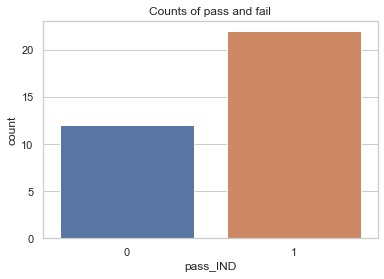

In [87]:
sns.countplot(x='pass_IND', data=df_clean).set_title('Counts of pass and fail')

In [88]:
grades = df_clean.iloc[:, 43:48]

In [89]:
cor_matrix = grades.corr()
cor_matrix.style.background_gradient(cmap='viridis_r')

,Session 2,Session 3,Session 4,Session 5,Session 6
Session 2,1,0.662718,0.42483,0.49168,0.359912
Session 3,0.662718,1,0.439425,0.439928,0.333721
Session 4,0.42483,0.439425,1,0.379807,0.482203
Session 5,0.49168,0.439928,0.379807,1,0.0594774
Session 6,0.359912,0.333721,0.482203,0.0594774,1


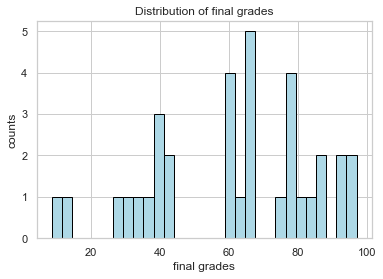

In [90]:
plt.hist(df['total'], color='lightblue', edgecolor='black', bins=30)
plt.xlabel("final grades")
plt.ylabel("counts")
plt.title("Distribution of final grades");

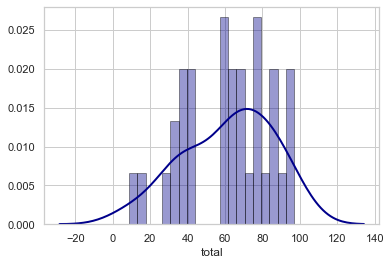

In [91]:
sns.distplot(df.total, hist=True, kde=True,
            bins=20, color='darkblue',
            hist_kws={'edgecolor':'black'},
            kde_kws={'linewidth': 2});

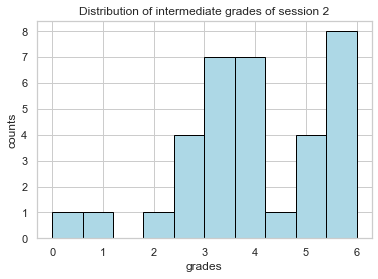

In [92]:
plt.hist(grades['Session 2'], color='lightblue', edgecolor='black')
plt.xlabel("grades")
plt.ylabel("counts")
plt.title("Distribution of intermediate grades of session 2");

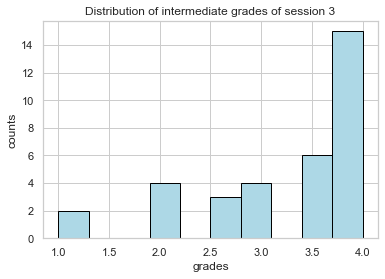

In [93]:
plt.hist(grades['Session 3'], color='lightblue', edgecolor='black')
plt.xlabel("grades")
plt.ylabel("counts")
plt.title("Distribution of intermediate grades of session 3");

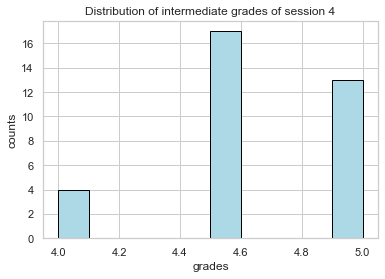

In [94]:
plt.hist(grades['Session 4'], color='lightblue', edgecolor='black')
plt.xlabel("grades")
plt.ylabel("counts")
plt.title("Distribution of intermediate grades of session 4");

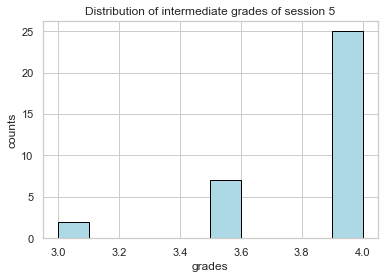

In [95]:
plt.hist(grades['Session 5'], color='lightblue', edgecolor='black')
plt.xlabel("grades")
plt.ylabel("counts")
plt.title("Distribution of intermediate grades of session 5");

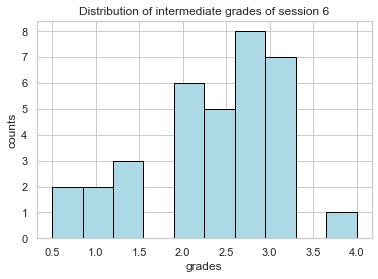

In [96]:
plt.hist(grades['Session 6'], color='lightblue', edgecolor='black')
plt.xlabel("grades")
plt.ylabel("counts")
plt.title("Distribution of intermediate grades of session 6");

**From the histograms of these intermediate grades, we can see that the grades are clustered to several groups in session 3, 4, and 5, just as the author of the dataset said, students can work together or just copy each others assignments, thus, intermediate grades are not reliable.**

Let's explore the behavior data:

In [97]:
sum_behv_passind=pd.merge(sum_behv, df, how='inner', left_on='student_Id', right_on='ID')
sum_behv_passind.head()

,student_Id,session,work_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke,ID,Session 2,Session 3,Session 4,Session 5,Session 6,ES 1.1 \n(2 points),ES 1.2 \n(3 points),ES 2.1\n(2 points),ES 2.2\n(3 points),ES 3.1\n(1 points),ES 3.2\n(2 points),ES 3.3\n(2 points),ES 3.4\n(2 points),ES 3.5\n(3 points),ES 4.1\n(15 points),ES 4.2\n(10 points),ES 5.1\n(2 points),ES 5.2\n(10 points),ES 5.3\n(3 points),ES 6.1\n(25 points),ES 6.2\n(15 points),total,pass_IND
0,2,1,4215.0,0,0,2,0,45,1047,2,4.0,3.5,4.5,4.0,1.0,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.0,1.5,5.0,0.0,44.0,0
1,2,2,8500.0,0,0,3696,98,69226,5151,2,4.0,3.5,4.5,4.0,1.0,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.0,1.5,5.0,0.0,44.0,0
2,2,3,9741.0,1379,0,5543,304,259130,4873,2,4.0,3.5,4.5,4.0,1.0,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.0,1.5,5.0,0.0,44.0,0
3,2,4,4095.0,826,0,1857,82,91633,2232,2,4.0,3.5,4.5,4.0,1.0,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.0,1.5,5.0,0.0,44.0,0
4,2,5,5128.0,1570,0,2211,164,122581,3142,2,4.0,3.5,4.5,4.0,1.0,2.0,3.0,2.0,0.5,1.0,2,0.0,2.0,3.0,15.0,2.0,0.0,5.0,1.5,5.0,0.0,44.0,0


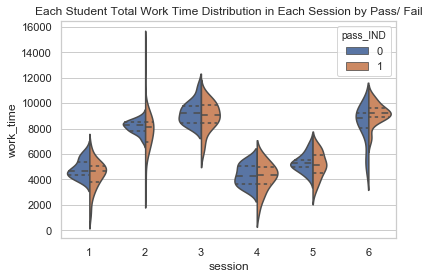

In [98]:
ax = sns.violinplot(x="session", y="work_time", hue="pass_IND", 
                    data=sum_behv_passind, split="True", inner="quartile").\
set_title("Each Student Total Work Time Distribution in Each Session by Pass/ Fail")

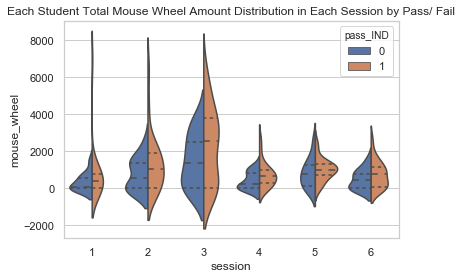

In [99]:
ax = sns.violinplot(x="session", y="mouse_wheel", hue="pass_IND", 
                    data=sum_behv_passind, split="True", inner="quartile").\
set_title("Each Student Total Mouse Wheel Amount Distribution in Each Session by Pass/ Fail")

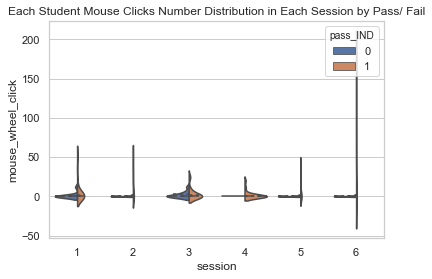

In [100]:
ax = sns.violinplot(x="session", y="mouse_wheel_click", hue="pass_IND", 
                    data=sum_behv_passind, split="True", inner="quartile").\
set_title("Each Student Mouse Clicks Number Distribution in Each Session by Pass/ Fail")

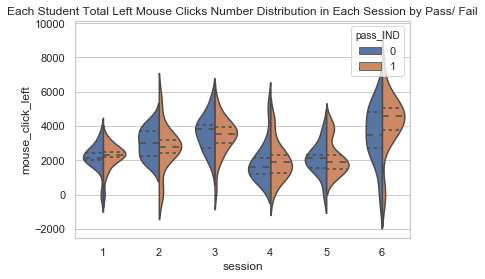

In [101]:
ax = sns.violinplot(x="session", y="mouse_click_left", hue="pass_IND", 
                    data=sum_behv_passind, split="True", inner="quartile").\
set_title("Each Student Total Left Mouse Clicks Number Distribution in Each Session by Pass/ Fail")

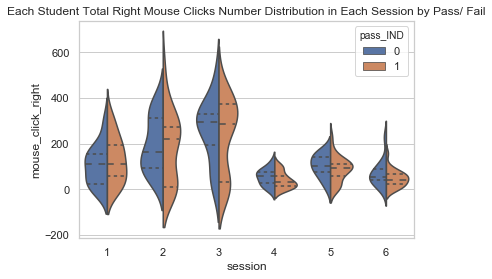

In [102]:
ax = sns.violinplot(x="session", y="mouse_click_right", hue="pass_IND", 
                    data=sum_behv_passind, split="True", inner="quartile").\
set_title("Each Student Total Right Mouse Clicks Number Distribution in Each Session by Pass/ Fail")

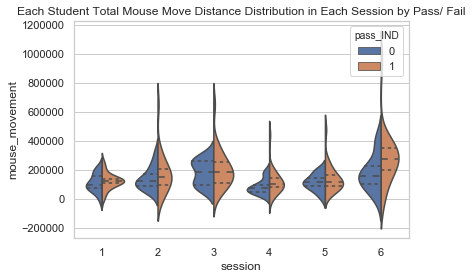

In [103]:
ax = sns.violinplot(x="session", y="mouse_movement", hue="pass_IND", 
                    data=sum_behv_passind, split="True", inner="quartile").\
set_title("Each Student Total Mouse Move Distance Distribution in Each Session by Pass/ Fail")

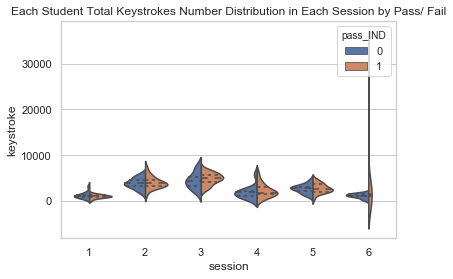

In [104]:
ax = sns.violinplot(x="session", y="keystroke", hue="pass_IND", 
                    data=sum_behv_passind, split="True", inner="quartile").\
set_title("Each Student Total Keystrokes Number Distribution in Each Session by Pass/ Fail")

# Classification

## Data Separation

In [105]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

In [106]:
df_clean.iloc[:, 1:43].head()

,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6
0,4215.0,8500.0,9741.0,4095.0,5128.0,5706.0,0.0,0.0,1379.0,826.0,1570.0,708.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3696.0,5543.0,1857.0,2211.0,2812.0,0.0,98.0,304.0,82.0,164.0,104.0,45.0,69226.0,259130.0,91633.0,122581.0,165494.0,1047.0,5151.0,4873.0,2232.0,3142.0,1140.0
1,4071.0,7754.0,8489.0,3252.0,5037.0,9027.0,586.0,1538.0,2069.0,489.0,1138.0,904.0,0.0,0.0,0.0,0.0,0.0,0.0,1977.0,4303.0,2703.0,1419.0,1924.0,4857.0,10.0,65.0,117.0,74.0,130.0,114.0,207317.0,317737.0,273721.0,119589.0,198103.0,427595.0,1207.0,5450.0,7433.0,2369.0,2701.0,1552.0
2,5086.0,7975.0,9421.0,4893.0,3465.0,8999.0,0.0,2145.0,728.0,342.0,1088.0,968.0,18.0,0.0,0.0,0.0,2.0,0.0,2238.0,2733.0,3761.0,1068.0,1088.0,3533.0,64.0,168.0,390.0,34.0,82.0,96.0,107269.0,207043.0,156059.0,61183.0,84820.0,241519.0,1745.0,3873.0,5159.0,3270.0,3491.0,727.0
3,4660.0,7736.0,8413.0,4976.0,5269.0,8151.0,573.0,1305.0,517.0,957.0,2577.0,1131.0,0.0,0.0,4.0,0.0,0.0,0.0,2244.0,3830.0,4709.0,5112.0,3855.0,4846.0,171.0,320.0,358.0,48.0,146.0,86.0,145381.0,226786.0,262458.0,183880.0,175403.0,246180.0,653.0,4299.0,2982.0,2394.0,2744.0,980.0
4,4908.0,8785.0,9968.0,2459.0,3959.0,9095.0,312.0,1153.0,153.0,539.0,888.0,493.0,0.0,0.0,0.0,0.0,0.0,0.0,2446.0,2987.0,323.0,1429.0,1826.0,4583.0,149.0,274.0,2.0,15.0,132.0,62.0,219138.0,302207.0,26362.0,125858.0,195455.0,381456.0,458.0,3534.0,2609.0,2138.0,1887.0,1084.0


Split dataset into training set and test set: 70% training and 30% test

In [107]:

X = preprocessing.scale(df_clean.iloc[:, 1:43].values)
X_features = df_clean.iloc[:, 1:43].columns
y = df_clean.iloc[:, 48].values


# Split dataset into training set and test set
# 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40) 

In [108]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (23, 42)
y_train shape: (23,)
X_test shape: (11, 42)
y_test shape: (11,)


In [109]:
y_test

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1])

## K Nearest Neighbors

### Building model

Start KNN classifier with 1 neighbor:

In [110]:
from sklearn.neighbors import KNeighborsClassifier
# start trying with neighbors = 1
knn = KNeighborsClassifier(n_neighbors=1)

Fit the model:

In [111]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

Make prediction:

In [112]:
# making predictions
y_pred = knn.predict(X_test)

Check accuracy:

In [113]:
np.mean(y_pred == y_test)

0.7272727272727273

Try with 3 neighbors:

In [114]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
np.mean(y_pred == y_test)

0.7272727272727273

Try with 5 neighbors:

In [115]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
np.mean(y_pred == y_test)

0.7272727272727273

Try with 1 to 15 neighbors:

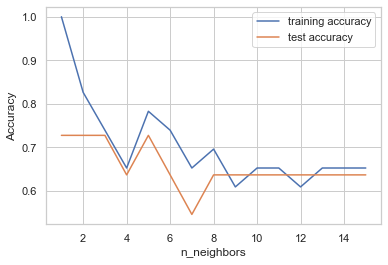

In [116]:
train_acc = []
test_acc = []
neighbors_set = range(1, 16)

for n_neighbors in neighbors_set:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    train_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))

plt.plot(neighbors_set, train_acc, label="training accuracy")
plt.plot(neighbors_set, test_acc, label="test accuracy")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.legend();

The plot shows that when we use 1 neighbor, the training accuracy reaches its peak value, while using 5 neighbors, we can get the highest test accuracy. 

In [117]:
max(test_acc)

0.7272727272727273

However, we cannot just use 5 neighbors as the best parameter, because the knowledge about the test set can leak into the model and evaluation metrics no longer report on generalization performance. To solve this problem, all the hyper-parameter choosing of models was achieved by cross-validation.

To be concise, the cross-validation method we used here is the k-fold cross-validation, with k = 5 for all models. The training set is split into 5 smaller sets, and the model is trained using 4 of the 5 folds as training data, after that, the resulting model is validated on the remaining part of the data. 

Grid search with cross validation for best number of neighbors:

In [118]:
knn_param_grid = dict(n_neighbors=range(1, 16))
knn = KNeighborsClassifier()

In [119]:
from sklearn.model_selection import GridSearchCV
knn_grid = GridSearchCV(knn, knn_param_grid, cv=5, verbose=0, iid=True)

In [120]:
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=True, n_jobs=None, param_grid={'n_neighbors': range(1, 16)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [121]:
knn_grid.best_params_

{'n_neighbors': 5}

In [122]:
knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

### Model evaluation

In [123]:
y_pred = knn_grid.predict(X_test)

**Confusion matrix and classification report:**

In [124]:
def print_clf_report(model_name):
    print('Confusion matrix of {}:'.format(model_name))
    print();
    print(confusion_matrix(y_test, y_pred))
    print();
    print('Classification report of {}:'.format(model_name))
    print();
    print(classification_report(y_test, y_pred))

In [125]:
print_clf_report('KNN')

Confusion matrix of KNN:

[[1 3]
 [0 7]]

Classification report of KNN:

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.70      1.00      0.82         7

    accuracy                           0.73        11
   macro avg       0.85      0.62      0.61        11
weighted avg       0.81      0.73      0.67        11



In the classification report, 0 stands for failed in final exam while 1 stands for passed final exam.

**Cross validation result:**

In [126]:
def print_cv_result(model_name):
    print(); print("Cross validation result of {}:".format(model_name))
    print(); print("Cross validation scores: {}".format(CV_result))
    print(); print("Mean of cross validation scores: {}".format(CV_result.mean()))
    print(); print("Standard deviation of cross validation scores: %0.2f" % CV_result.std())
    print(); print("Coefficient of Variation in CV result: %0.2f" % (CV_result.std()/CV_result.mean()))

In [127]:
CV_result = cross_val_score(knn_grid.best_estimator_, X_train, y_train, cv=5)

In [128]:
print_cv_result(model_name='KNN')


Cross validation result of KNN:

Cross validation scores: [0.6  0.8  0.6  0.5  0.75]

Mean of cross validation scores: 0.65

Standard deviation of cross validation scores: 0.11

Coefficient of Variation in CV result: 0.17


**ROC curve:**

In [129]:
def plot_roc(model_name):
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve of {}'.format(model_name))
    plt.show()

In [130]:
y_scores = knn_grid.predict_proba(X_test)

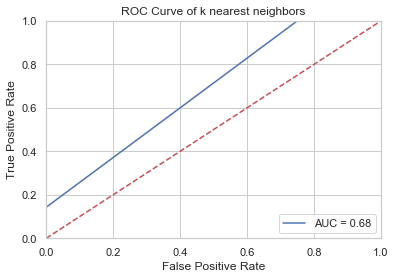

In [131]:
plot_roc('k nearest neighbors')

## Support Vector Machine

### Building model

Start with default SVM settings:

In [132]:
from sklearn.svm import SVC
svc = SVC(gamma='scale', random_state=1115)

In [133]:
svc.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=1115, shrinking=True,
    tol=0.001, verbose=False)

In [134]:
y_pred = svc.predict(X_test)

In [135]:
print_clf_report('SVM')

Confusion matrix of SVM:

[[0 4]
 [0 7]]

Classification report of SVM:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.64      1.00      0.78         7

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11



/Users/zhenghaoxiao/anaconda3/envs/my_env/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Try to search with best parameter with grid search cross validation:

In [136]:
svm_param_grid = {'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001], 
                  'kernel':["linear", "poly", "rbf", "sigmoid"]}

In [137]:
svm_grid = GridSearchCV(SVC(random_state=1115), svm_param_grid, cv=5, verbose=0, iid=False)

In [138]:
svm_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=1115, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [139]:
svm_grid.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'sigmoid'}

In [140]:
svm_grid.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=1115, shrinking=True,
    tol=0.001, verbose=False)

### Model evaluation

In [141]:
y_pred = svm_grid.predict(X_test)

In [142]:
print_clf_report('SVM')

Confusion matrix of SVM:

[[3 1]
 [3 4]]

Classification report of SVM:

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.80      0.57      0.67         7

    accuracy                           0.64        11
   macro avg       0.65      0.66      0.63        11
weighted avg       0.69      0.64      0.64        11



In [143]:
CV_result = cross_val_score(svm_grid.best_estimator_, X_train, y_train, cv=5)

In [144]:
print_cv_result('SVM')


Cross validation result of SVM:

Cross validation scores: [0.6 0.8 0.6 0.5 1. ]

Mean of cross validation scores: 0.7

Standard deviation of cross validation scores: 0.18

Coefficient of Variation in CV result: 0.26


## Logistic Regression

### Building model

Start with default settings:

In [145]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=1115, solver='lbfgs')

In [146]:
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1115, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [147]:
y_pred = logreg.predict(X_test)

In [148]:
print_clf_report('Logistic regression')

Confusion matrix of Logistic regression:

[[2 2]
 [4 3]]

Classification report of Logistic regression:

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.60      0.43      0.50         7

    accuracy                           0.45        11
   macro avg       0.47      0.46      0.45        11
weighted avg       0.50      0.45      0.46        11



Try with different C values:

In [149]:
C = np.logspace(0, 3, 10)

logr_param_grid = dict(C=C)
logr_grid = GridSearchCV(LogisticRegression(random_state=1115, solver='lbfgs'), logr_param_grid, 
                    cv=5, iid=False, verbose=0)

In [150]:
logr_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=1115, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid=False, n_jobs=None,
             param_grid={'C': array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [151]:
logr_grid.best_params_

{'C': 1.0}

In [152]:
logr_grid.best_estimator_

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1115, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Model evaluation

In [153]:
y_pred = logr_grid.predict(X_test)

In [154]:
print_clf_report('Logistic regression')

Confusion matrix of Logistic regression:

[[2 2]
 [4 3]]

Classification report of Logistic regression:

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.60      0.43      0.50         7

    accuracy                           0.45        11
   macro avg       0.47      0.46      0.45        11
weighted avg       0.50      0.45      0.46        11



In [155]:
CV_result = cross_val_score(logr_grid.best_estimator_, X_train, y_train, cv=5)

In [156]:
print_cv_result('Logsitic regression')


Cross validation result of Logsitic regression:

Cross validation scores: [0.6  0.8  0.8  0.25 0.75]

Mean of cross validation scores: 0.64

Standard deviation of cross validation scores: 0.21

Coefficient of Variation in CV result: 0.33


## Decision Tree

### Building model

Start from default settings:

In [157]:
from sklearn.tree import DecisionTreeClassifier

In [158]:
dtree = DecisionTreeClassifier(random_state=1115)

In [159]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1115, splitter='best')

In [160]:
y_pred = dtree.predict(X_test)

In [161]:
print_clf_report('Decision tree')

Confusion matrix of Decision tree:

[[1 3]
 [1 6]]

Classification report of Decision tree:

              precision    recall  f1-score   support

           0       0.50      0.25      0.33         4
           1       0.67      0.86      0.75         7

    accuracy                           0.64        11
   macro avg       0.58      0.55      0.54        11
weighted avg       0.61      0.64      0.60        11



Try with different parameters: criterion and max tree depth

In [162]:
dtree = DecisionTreeClassifier(random_state=1115)

In [163]:
criterion = ['gini', 'entropy']
max_depth = [2, 4, 6, 8, 10, 12]

In [164]:
dtree_param_grid = dict(criterion=criterion,
                        max_depth=max_depth)

In [165]:
dtree_grid = GridSearchCV(dtree, dtree_param_grid, cv=5, verbose=0, iid=False)

In [166]:
dtree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=1115,
                                              splitter='best'),
             iid=False, n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12]},
             pre_

In [167]:
dtree_grid.best_params_

{'criterion': 'entropy', 'max_depth': 2}

In [168]:
dtree_grid.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1115, splitter='best')

### Model evaluation

In [169]:
y_pred = dtree_grid.predict(X_test)

In [170]:
print_clf_report('Decision tree')

Confusion matrix of Decision tree:

[[2 2]
 [7 0]]

Classification report of Decision tree:

              precision    recall  f1-score   support

           0       0.22      0.50      0.31         4
           1       0.00      0.00      0.00         7

    accuracy                           0.18        11
   macro avg       0.11      0.25      0.15        11
weighted avg       0.08      0.18      0.11        11



In [171]:
CV_result = cross_val_score(dtree_grid.best_estimator_, X_train, y_train, cv=5)

In [172]:
print_cv_result('Decision tree')


Cross validation result of Decision tree:

Cross validation scores: [0.4  0.6  0.8  0.5  0.25]

Mean of cross validation scores: 0.51

Standard deviation of cross validation scores: 0.19

Coefficient of Variation in CV result: 0.36


## Random Forest

### Building model

In [173]:
from sklearn.ensemble import RandomForestClassifier

In [174]:
rfc = RandomForestClassifier(n_estimators=100, random_state=1115)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1115,
                       verbose=0, warm_start=False)

In [175]:
y_pred = rfc.predict(X_test)

In [176]:
print_clf_report('Random forest')

Confusion matrix of Random forest:

[[2 2]
 [1 6]]

Classification report of Random forest:

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.75      0.86      0.80         7

    accuracy                           0.73        11
   macro avg       0.71      0.68      0.69        11
weighted avg       0.72      0.73      0.72        11



We can try to adjust the hyper-parameter: number of estimators

In [177]:
rfc = RandomForestClassifier(random_state=1115)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]

In [178]:
rfc_param_grid = {'n_estimators': n_estimators}

In [179]:
rfc_grid = GridSearchCV(rfc, rfc_param_grid, cv=5, verbose=0, iid=False)

In [180]:
rfc_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=1115, verbose=0,
                                              warm_start=False),
             iid

In [181]:
rfc_grid.best_params_

{'n_estimators': 100}

In [182]:
rfc_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1115,
                       verbose=0, warm_start=False)

### Model evaluation

In [183]:
y_pred = rfc_grid.predict(X_test)

In [184]:
print_clf_report('Random forest')

Confusion matrix of Random forest:

[[2 2]
 [1 6]]

Classification report of Random forest:

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.75      0.86      0.80         7

    accuracy                           0.73        11
   macro avg       0.71      0.68      0.69        11
weighted avg       0.72      0.73      0.72        11



In [185]:
CV_result = cross_val_score(rfc_grid.best_estimator_, X_train, y_train, cv=5)

In [186]:
print_cv_result('Random forest')


Cross validation result of Random forest:

Cross validation scores: [0.4  0.6  0.6  0.75 0.75]

Mean of cross validation scores: 0.62

Standard deviation of cross validation scores: 0.13

Coefficient of Variation in CV result: 0.21


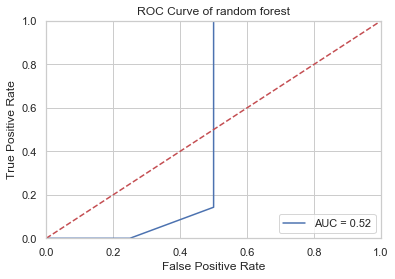

In [187]:
y_scores = rfc_grid.predict_proba(X_test)
plot_roc('random forest')

## Naive Bayes

### Building model

Probability-based model: Naive Bayes always does a good job of handling high-dimensional data, based on EDA of the logs data, we assume all those continuous features follow the Gaussian probability density distribution, so we used GaussianNB to fit our model:

In [188]:
from sklearn.naive_bayes import GaussianNB

In [189]:
gnb = GaussianNB()

In [190]:
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [191]:
y_pred = gnb.predict(X_test)

In [192]:
print_clf_report('Naive Bayes')

Confusion matrix of Naive Bayes:

[[3 1]
 [3 4]]

Classification report of Naive Bayes:

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.80      0.57      0.67         7

    accuracy                           0.64        11
   macro avg       0.65      0.66      0.63        11
weighted avg       0.69      0.64      0.64        11



In [193]:
gnb_param_grid = {'var_smoothing': [1e-09, 1e-08, 1e-07]}

In [194]:
gnb_grid = GridSearchCV(gnb, gnb_param_grid, cv=5, verbose=0, iid=False)

In [195]:
gnb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid=False,
             n_jobs=None, param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [196]:
gnb_grid.best_params_

{'var_smoothing': 1e-09}

In [197]:
gnb_grid.best_estimator_

GaussianNB(priors=None, var_smoothing=1e-09)

### Model evaluation

In [198]:
y_pred = gnb_grid.predict(X_test)

In [199]:
print_clf_report('Naive Bayes')

Confusion matrix of Naive Bayes:

[[3 1]
 [3 4]]

Classification report of Naive Bayes:

              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.80      0.57      0.67         7

    accuracy                           0.64        11
   macro avg       0.65      0.66      0.63        11
weighted avg       0.69      0.64      0.64        11



In [200]:
CV_result = cross_val_score(gnb_grid.best_estimator_, X_train, y_train, cv=5)

In [201]:
print_cv_result('Naive Bayes')


Cross validation result of Naive Bayes:

Cross validation scores: [0.4  0.6  0.4  0.25 0.5 ]

Mean of cross validation scores: 0.43

Standard deviation of cross validation scores: 0.12

Coefficient of Variation in CV result: 0.27


## XGBoost

### Building model

Start with default setting:

In [202]:
from xgboost import XGBClassifier

In [203]:
xgb = XGBClassifier(random_state=1115)

In [204]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1115,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [205]:
y_pred = xgb.predict(X_test)

In [206]:
print_clf_report('XGBoost')

Confusion matrix of XGBoost:

[[2 2]
 [2 5]]

Classification report of XGBoost:

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.71      0.71      0.71         7

    accuracy                           0.64        11
   macro avg       0.61      0.61      0.61        11
weighted avg       0.64      0.64      0.64        11



Try with a smaller learning rate:

In [207]:
xgb = XGBClassifier(learning_rate=0.01, random_state=1115)

In [208]:
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print_clf_report('XGBoost')

Confusion matrix of XGBoost:

[[1 3]
 [2 5]]

Classification report of XGBoost:

              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.62      0.71      0.67         7

    accuracy                           0.55        11
   macro avg       0.48      0.48      0.48        11
weighted avg       0.52      0.55      0.53        11



Grid Search for best-generalized parameters:

In [209]:
xgb_param_grid = {'learning_rate': [1, 0.1, 0.01, 0.001, 0.0001], 
                  'n_estimators': [50, 100, 200, 300]}
xgb = XGBClassifier(random_state=1115)

Grid search with k-fold cross validation:

In [210]:
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=5, verbose=0, iid=True)

In [211]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=1115, reg_alpha=0,
                                     reg_lambda=1, scale_pos_weight=1,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid=True, n_jobs=None,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001, 0.0001],
                         'n_estimators': [50, 100, 200, 

In [212]:
xgb_grid.best_params_

{'learning_rate': 0.01, 'n_estimators': 50}


### Model evaluation

In [213]:
y_pred = xgb_grid.predict(X_test)

In [214]:
print_clf_report('XGBoost')

Confusion matrix of XGBoost:

[[2 2]
 [4 3]]

Classification report of XGBoost:

              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.60      0.43      0.50         7

    accuracy                           0.45        11
   macro avg       0.47      0.46      0.45        11
weighted avg       0.50      0.45      0.46        11



In [215]:
CV = cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv=5)

In [216]:
print_cv_result('XGBoost')


Cross validation result of XGBoost:

Cross validation scores: [0.4  0.6  0.4  0.25 0.5 ]

Mean of cross validation scores: 0.43

Standard deviation of cross validation scores: 0.12

Coefficient of Variation in CV result: 0.27


## Model Selection

There are total 7 models used in classification: K nearest neighbors, support vector machine, logistic regression, decision tree, random forest, naive Bayes, and XGBoost. We chose Naive Bayes as the baseline model because it is easy to deploy and always has a good performance for high-dimensional data. 

| Model | K nearest neighbors | support vector machine | logistic regression | decision tree | random forest | naive Bayes | XGBoost |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Accuracy | 0.73 | 0.64 | 0.45 | 0.18 | 0.73 | 0.64 | 0.45 |

According to our evaluations of each model, two of the models have the highest accuracy 0.73: K nearest neighbors and random forest. This is not a good performance in regards of predicting. However, since we have only 34 observations: 23 of them are assigned to training and 11 of them are assigned to test, our models are unstable. All classifiers need enough amount of sample size for them to engage their power. With too few training cases, all those classifier models are unstable, that is, if we use another random state in the data split part, the results of each model will change a lot. For model comparisons, We need at least several hundred test cases to get accurate test scores. 

There is a criterion that measures the stability of our models: the variation in cross validation result, which is the standard deviation divided by the mean of the cross validation scores. The higher the variation, more unstable the model is.



| Model | K nearest neighbors | support vector machine | logistic regression | decision tree | random forest | naive Bayes | XGBoost |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Variation in cross validation result | 17% | 26% | 33% | 36% | 21% | 27% | 27% |

In addition, the receiver operating characteristic (ROC curve) and area under curve (AUC) also illustrated that random forest (AUC = 0.52) was outperformed by k nearest neighbors (AUC = 0.68) in our classification mission: notice that because of the small test data size, the ROC curves are lack of fluctuation.

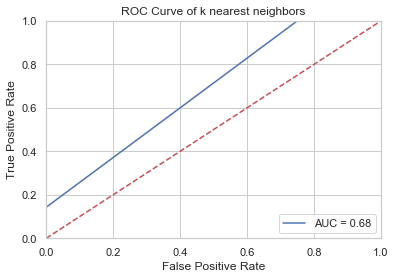

In [217]:
y_scores = knn_grid.predict_proba(X_test)
plot_roc('k nearest neighbors')

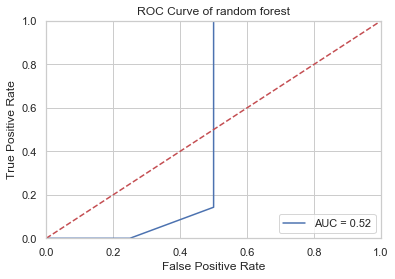

In [218]:
y_scores = rfc_grid.predict_proba(X_test)
plot_roc('random forest')

Besides, in reality, the data may change over time, since the Deeds system has 6 sessions, it keeps recording data from session 1 to session 6, if we can only give prediction after all the sessions ended, which is close to the end of the semester, the model will be less meaningful for the instructors to use as a reference to warning those who-may-fail-at-final students. Similarity-based model such as KNN can deal with those kind of models that can be incrementally retrained. 

**In a nutshell, we choose the K Nearest Neighbors as our model classifier due to its performance and the ability to be incrementally retrained.**

# Clustering

We use K-means clustering method to cluster the students based on their behavior data:

In [219]:
from sklearn.cluster import KMeans

The biggest disadvantage of K-Means clustering is that we need to specify the number of the clusters before we start clustering, however, we do have some methods to improve that disadvantage: elbow method. This method is a useful graphic tool to estimate the optimal number of clusters. In general, if the number of clusters increase, the within-cluster SSE (distortion) will decrease. This is because with the increasing of number of clusters, the samples will be closer to the centroids they are assigned to. 

We can use elbow method to estimate the optimal number of clusters:

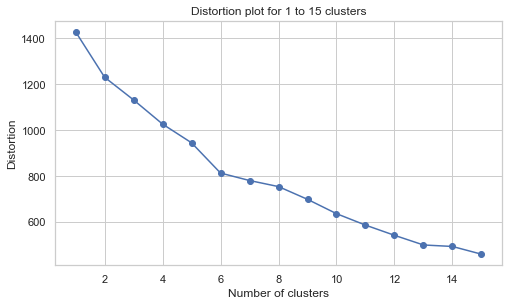

In [220]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 16):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.figure(figsize=(8,4.5))
plt.plot(range(1, 16), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Distortion plot for 1 to 15 clusters')
plt.show()

Where the distortion begins to decrease more rapidly should be a good choice for our dataset. In our case, although it is not obvious, the number of cluster related to this rapid decreasing should be 6. 

We can see that the slope of distortion did not decrease a lot, this means the data cannot be clustered well, the variances in each cluster are still big. We can check it again by increase the number of clusters even more:

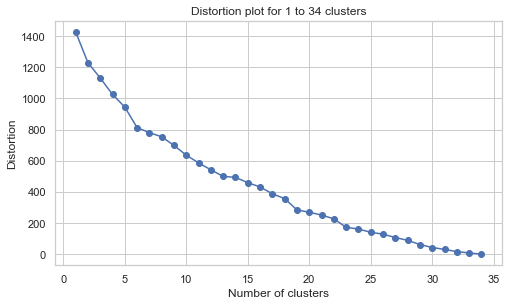

In [221]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 35):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.figure(figsize=(8,4.5))
plt.plot(range(1, 35), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Distortion plot for 1 to 34 clusters')
plt.show()

We can see there is a relatively big slope change where number of clusters equals to 6. 

In [222]:
km = KMeans(n_clusters=6, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=1115)
y_km = km.fit_predict(X)
y_km

array([5, 5, 5, 2, 1, 5, 2, 5, 5, 2, 5, 5, 5, 3, 4, 5, 5, 2, 5, 5, 1, 3,
       0, 5, 5, 5, 2, 2, 2, 2, 5, 5, 2, 5], dtype=int32)

In [223]:
df_clean['cluster'] = y_km
df_clean.head()

,student_Id,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6,Session 2,Session 3,Session 4,Session 5,Session 6,pass_IND,cluster
0,2,4215.0,8500.0,9741.0,4095.0,5128.0,5706.0,0.0,0.0,1379.0,826.0,1570.0,708.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3696.0,5543.0,1857.0,2211.0,2812.0,0.0,98.0,304.0,82.0,164.0,104.0,45.0,69226.0,259130.0,91633.0,122581.0,165494.0,1047.0,5151.0,4873.0,2232.0,3142.0,1140.0,4.0,3.5,4.5,4.0,1.00,0,5
1,5,4071.0,7754.0,8489.0,3252.0,5037.0,9027.0,586.0,1538.0,2069.0,489.0,1138.0,904.0,0.0,0.0,0.0,0.0,0.0,0.0,1977.0,4303.0,2703.0,1419.0,1924.0,4857.0,10.0,65.0,117.0,74.0,130.0,114.0,207317.0,317737.0,273721.0,119589.0,198103.0,427595.0,1207.0,5450.0,7433.0,2369.0,2701.0,1552.0,5.0,4.0,5.0,4.0,2.75,0,5
2,7,5086.0,7975.0,9421.0,4893.0,3465.0,8999.0,0.0,2145.0,728.0,342.0,1088.0,968.0,18.0,0.0,0.0,0.0,2.0,0.0,2238.0,2733.0,3761.0,1068.0,1088.0,3533.0,64.0,168.0,390.0,34.0,82.0,96.0,107269.0,207043.0,156059.0,61183.0,84820.0,241519.0,1745.0,3873.0,5159.0,3270.0,3491.0,727.0,4.0,4.0,4.5,4.0,2.00,1,5
3,10,4660.0,7736.0,8413.0,4976.0,5269.0,8151.0,573.0,1305.0,517.0,957.0,2577.0,1131.0,0.0,0.0,4.0,0.0,0.0,0.0,2244.0,3830.0,4709.0,5112.0,3855.0,4846.0,171.0,320.0,358.0,48.0,146.0,86.0,145381.0,226786.0,262458.0,183880.0,175403.0,246180.0,653.0,4299.0,2982.0,2394.0,2744.0,980.0,5.0,4.0,4.5,4.0,3.00,0,2
4,11,4908.0,8785.0,9968.0,2459.0,3959.0,9095.0,312.0,1153.0,153.0,539.0,888.0,493.0,0.0,0.0,0.0,0.0,0.0,0.0,2446.0,2987.0,323.0,1429.0,1826.0,4583.0,149.0,274.0,2.0,15.0,132.0,62.0,219138.0,302207.0,26362.0,125858.0,195455.0,381456.0,458.0,3534.0,2609.0,2138.0,1887.0,1084.0,4.0,2.0,5.0,4.0,1.50,1,1


We can do some exploratory analysis to check the result of the clustering:

In [224]:
df_clean.cluster.value_counts()

5    19
2     9
3     2
1     2
4     1
0     1
Name: cluster, dtype: int64

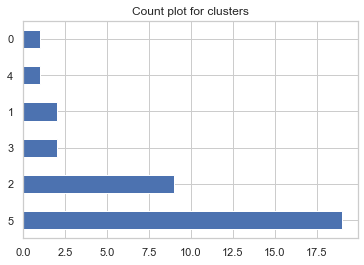

In [225]:
df_clean.cluster.value_counts().plot(kind='barh')
plt.title('Count plot for clusters');

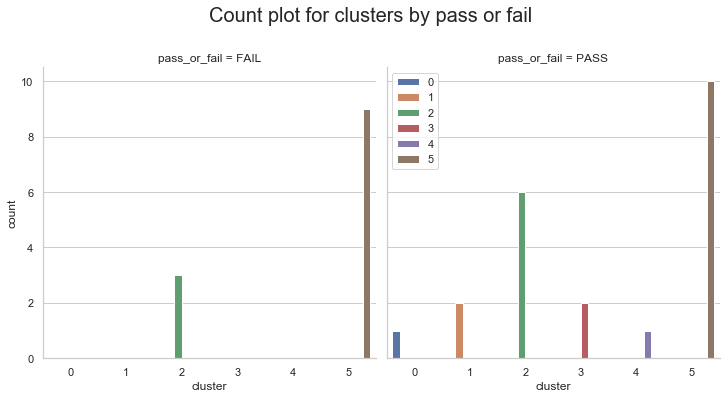

In [226]:
df_clean_copy = df_clean.copy()
df_clean_copy["pass_or_fail"] = ["PASS" if x == 1 else "FAIL" for x in df_clean_copy["pass_IND"]]

g = sns.catplot(x='cluster', hue='cluster', data=df_clean_copy, col="pass_or_fail",kind="count")

plt.legend(loc='upper left')
g.fig.suptitle("\n\n".join(['Count plot for clusters by pass or fail']),fontsize=20, y=1.1);

This plot shows the counts of clusters by pass or fail the final exam. There are 4 clusters that all students within them passed the final exam. In spite of the relative low accuracy of our classifiers, we still get some findings in K-Means clustering. We can check the attributes of cluster 0, 1, 3, and 4 to see if they have some features in common:

In [227]:
df_clean.loc[df_clean.cluster.isin([0, 1, 3, 4])]

,student_Id,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6,Session 2,Session 3,Session 4,Session 5,Session 6,pass_IND,cluster
4,11,4908.0,8785.0,9968.0,2459.0,3959.0,9095.0,312.0,1153.0,153.0,539.0,888.0,493.0,0.0,0.0,0.0,0.0,0.0,0.0,2446.0,2987.0,323.0,1429.0,1826.0,4583.0,149.0,274.0,2.0,15.0,132.0,62.0,219138.0,302207.0,26362.0,125858.0,195455.0,381456.0,458.0,3534.0,2609.0,2138.0,1887.0,1084.0,4.0,2.0,5.0,4.0,1.50,1,1
13,39,5099.0,8371.0,7442.0,4451.0,6397.0,8971.0,830.0,862.0,3856.0,834.0,921.0,1202.0,52.0,24.0,10.0,20.0,38.0,62.0,2526.0,2611.0,4482.0,2377.0,3777.0,4882.0,331.0,206.0,281.0,102.0,170.0,68.0,126575.0,123063.0,190050.0,104075.0,150790.0,267954.0,1553.0,5182.0,6397.0,1880.0,3720.0,1321.0,3.0,1.0,4.5,3.5,2.50,1,3
14,44,3623.0,8552.0,8274.0,4621.0,6278.0,9596.0,951.0,2374.0,6205.0,2725.0,2097.0,1642.0,0.0,0.0,0.0,2.0,0.0,0.0,2376.0,5677.0,4296.0,4306.0,3860.0,7730.0,2.0,8.0,14.0,42.0,16.0,25.0,256801.0,648982.0,652163.0,442229.0,477397.0,955690.0,1389.0,7330.0,4835.0,6230.0,4518.0,2818.0,5.5,4.0,4.5,4.0,3.00,1,4
20,66,2979.0,13764.0,6180.0,1478.0,5113.0,9880.0,1434.0,6457.0,2960.0,0.0,1175.0,1289.0,0.0,0.0,0.0,0.0,0.0,0.0,2302.0,5016.0,1796.0,565.0,1388.0,5075.0,112.0,529.0,148.0,0.0,53.0,90.0,123443.0,301295.0,106836.0,27659.0,41410.0,391809.0,786.0,5226.0,2616.0,1656.0,2858.0,30448.0,0.0,2.0,4.5,3.0,2.25,1,1
21,67,3765.0,6548.0,8102.0,3430.0,4968.0,7041.0,441.0,1910.0,4037.0,682.0,2509.0,2620.0,0.0,51.0,24.0,6.0,38.0,170.0,2326.0,3813.0,4780.0,2834.0,3748.0,3920.0,290.0,372.0,346.0,52.0,230.0,58.0,96551.0,330602.0,356067.0,194313.0,265130.0,360937.0,524.0,3129.0,4074.0,1707.0,2504.0,1718.0,5.5,4.0,4.5,4.0,2.75,1,3
22,70,3959.0,8533.0,8615.0,4631.0,3928.0,10547.0,14.0,0.0,2781.0,1010.0,1242.0,0.0,0.0,2.0,25.0,12.0,0.0,0.0,16.0,3.0,3494.0,3416.0,1803.0,0.0,0.0,0.0,383.0,24.0,108.0,0.0,2050.0,148.0,179536.0,142267.0,89810.0,0.0,1023.0,4618.0,5599.0,252.0,2027.0,2162.0,5.5,4.0,5.0,4.0,3.25,1,0


In [228]:
df_cluster = df_clean.groupby(['cluster'], as_index=False).mean()

In [229]:
df_cluster

,cluster,student_Id,work_time1,work_time2,work_time3,work_time4,work_time5,work_time6,mouse_wheel1,mouse_wheel2,mouse_wheel3,mouse_wheel4,mouse_wheel5,mouse_wheel6,mouse_wheel_click1,mouse_wheel_click2,mouse_wheel_click3,mouse_wheel_click4,mouse_wheel_click5,mouse_wheel_click6,mouse_click_left1,mouse_click_left2,mouse_click_left3,mouse_click_left4,mouse_click_left5,mouse_click_left6,mouse_click_right1,mouse_click_right2,mouse_click_right3,mouse_click_right4,mouse_click_right5,mouse_click_right6,mouse_movement1,mouse_movement2,mouse_movement3,mouse_movement4,mouse_movement5,mouse_movement6,keystroke1,keystroke2,keystroke3,keystroke4,keystroke5,keystroke6,Session 2,Session 3,Session 4,Session 5,Session 6,pass_IND
0,0,70.000000,3959.000000,8533.000000,8615.000000,4631.000000,3928.000000,10547.000000,14.000000,0.000000,2781.000000,1010.000000,1242.000000,0.000000,0.000000,2.000000,25.000000,12.0,0.000000,0.000000,16.000000,3.000000,3494.000000,3416.000000,1803.000000,0.000000,0.000000,0.000000,383.000000,24.000000,108.000000,0.000000,2050.000000,148.000000,179536.000000,142267.000000,89810.000000,0.000000,1023.000000,4618.000000,5599.000000,252.000000,2027.000000,2162.000000,5.500000,4.000000,5.000000,4.000000,3.250000,1.000000
1,1,38.500000,3943.500000,11274.500000,8074.000000,1968.500000,4536.000000,9487.500000,873.000000,3805.000000,1556.500000,269.500000,1031.500000,891.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2374.000000,4001.500000,1059.500000,997.000000,1607.000000,4829.000000,130.500000,401.500000,75.000000,7.500000,92.500000,76.000000,171290.500000,301751.000000,66599.000000,76758.500000,118432.500000,386632.500000,622.000000,4380.000000,2612.500000,1897.000000,2372.500000,15766.000000,2.000000,2.000000,4.750000,3.500000,1.875000,1.000000
2,2,61.000000,4469.222222,7946.000000,9261.777778,4497.444444,5058.111111,8597.444444,387.444444,1349.000000,2615.111111,769.555556,1258.666667,1001.444444,1.333333,0.222222,1.777778,0.0,0.000000,0.222222,2368.666667,2966.666667,3710.555556,2018.555556,2120.000000,4602.555556,205.222222,278.555556,379.222222,26.333333,114.888889,90.777778,129649.666667,174697.777778,215594.555556,111046.888889,129842.666667,293272.555556,791.000000,3440.333333,4301.666667,2104.111111,2099.222222,1172.333333,4.500000,3.611111,4.722222,3.833333,2.250000,0.666667
3,3,53.000000,4432.000000,7459.500000,7772.000000,3940.500000,5682.500000,8006.000000,635.500000,1386.000000,3946.500000,758.000000,1715.000000,1911.000000,26.000000,37.500000,17.000000,13.0,38.000000,116.000000,2426.000000,3212.000000,4631.000000,2605.500000,3762.500000,4401.000000,310.500000,289.000000,313.500000,77.000000,200.000000,63.000000,111563.000000,226832.500000,273058.500000,149194.000000,207960.000000,314445.500000,1038.500000,4155.500000,5235.500000,1793.500000,3112.000000,1519.500000,4.250000,2.500000,4.500000,3.750000,2.625000,1.000000
4,4,44.000000,3623.000000,8552.000000,8274.000000,4621.000000,6278.000000,9596.000000,951.000000,2374.000000,6205.000000,2725.000000,2097.000000,1642.000000,0.000000,0.000000,0.000000,2.0,0.000000,0.000000,2376.000000,5677.000000,4296.000000,4306.000000,3860.000000,7730.000000,2.000000,8.000000,14.000000,42.000000,16.000000,25.000000,256801.000000,648982.000000,652163.000000,442229.000000,477397.000000,955690.000000,1389.000000,7330.000000,4835.000000,6230.000000,4518.000000,2818.000000,5.500000,4.000000,4.500000,4.000000,3.000000,1.000000
5,5,47.421053,4714.210526,7680.578947,9261.052632,4372.684211,5299.315789,8897.473684,651.421053,788.842105,1300.631579,477.894737,650.736842,344.315789,2.000000,2.947368,1.263158,0.0,0.421053,0.526316,2190.052632,2608.052632,3450.842105,1751.157895,1996.947368,3615.526316,73.789474,129.894737,186.842105,55.684211,75.684211,41.421053,109563.421053,119855.578947,174178.526316,87675.000000,114443.315789,177909.736842,1322.157895,3966.421053,5052.684211,2151.421053,3014.105263,1142.473684,3.684211,3.210526,4.578947,3.868421,2.263158,0.526316


However, since we have 42 features, it is hard to identify which of the feature contribute to the result that all students of those clusters passed the final exam. And as the distortion curve shows, those clusters are not very different with each other, they still have large in-cluster variance.


# Conclusions

We built seven classification models then picked k nearest neighbor classifier as the final model with accuracy of 0.73 on test set due to its performance and ability to be incrementally retrained. For clustering, we used k-means clustering with 6 clusters. All the students of cluster 0, 1, 3, 4 passed the final exam. 

As we mentioned before, the biggest problem in our work is that we have a small data size. We cannot get stable model based on those data. Another thing we tried is to get better features by process mining. In the article 'Learning Analytics and Educational Data Mining for Inquiry-Based Learning', Doctor Mehrnoosh Vahdat provided an insight to use Cyclomatic Complexity of McCabe (CM) of the result of process mining on session logs data with cases allocated per student per session as a measurement of difficulty a student feel in a session. We tried to follow this path to extract a new feature CM, we applied process mining on sessions data by Pm4py module, but failed to calculate CM for each cases because of the discrepancy between the required format of calculating CM with popular modules in Python and the format of data we gained from process mining by Pm4py.